In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 8
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [3]:
import rioxarray
import pathlib
import geopandas
import pandas
import shapely
import numpy

In [4]:
cache_path = pathlib.Path(fr"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
dems = {}
dems["Unconditioned"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_unconditioned.nc", masked=True).squeeze("band", drop=True)
dems["Wide uniform flow"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_rupp_and_smart_wide.nc", masked=True).squeeze("band", drop=True)
dems["Wide conceptual multivariate regression"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_rupp_and_smart_narrow.nc", masked=True).squeeze("band", drop=True)
dems["Narrow uniform flow"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_neal_et_al_wide.nc", masked=True).squeeze("band", drop=True)
dems["Narrow conceptual multivariate regression "] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_neal_et_al_narrow.nc", masked=True).squeeze("band", drop=True)

In [5]:
river_centreline = geopandas.read_file(cache_path / folder / "wide_river" / "aligned_river_centreline_6308000000.geojson")
river_polygon = geopandas.read_file(cache_path / folder / "wide_river" / "river_polygon.geojson")
fan_polygon = geopandas.read_file(cache_path / folder / "wide_river" / "fan_polygon.geojson")

In [6]:
polygon = geopandas.GeoDataFrame( pandas.concat([river_polygon, fan_polygon], ignore_index=True), crs=river_polygon.crs).dissolve()

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [7]:
sections_path = pathlib.Path(fr"C:\Local\data\river_bathemetry\sections\Westport\3738_Buller_River_October_2021")
cross_section_elevation_label = 'Elevation'
cross_section_name_label = 'Name'
measured_sections = geopandas.read_file(sections_path / "3738_Buller_River_October_2021.geojson")
all_measured_sections = ['Section1', 'Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5', 'Section6',
                             'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13', 'Section14',
                             'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25', 'Section26', 'Section17',
                             'Section18', 'Section19', 'Section20']
ordered_measured_sections = ['Section1', 'Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5', 'Section6',
                             'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13', 'Section14',
                             'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25', 'Section26']

In [8]:
measured_sections.head(1)

Chainage  Offset       North        East  Elevation   Descriptio      Name  \
0         0       0  5379501.17  1482467.51       0.48  TEMPMARK1LA  Section1   

   lvd_conversion  z_2016                                 geometry  
0           0.363   0.117  POINT Z (1482467.510 5379501.170 0.117)

### Simplify the measured points to min point/line strings

In [9]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections[cross_section_name_label].unique():
    measured_section = measured_sections[measured_sections[cross_section_name_label] == section]
    measured_centre = measured_section[measured_section[cross_section_elevation_label]==measured_section[cross_section_elevation_label].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y, measure_point.z] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section[cross_section_elevation_label].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=horizontal_crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=horizontal_crs)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<Axes: >

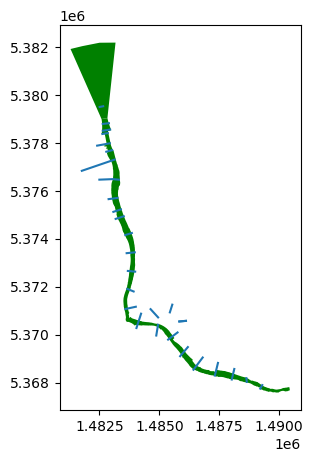

In [10]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
polygon.plot(ax=ax, color='g')
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [11]:
comparisons_sampled = {**dict((f"{key} z", []) for key in dems), **{"Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        for key in dems:
            comparisons_sampled[f"{key} z"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4
Section number = 5
Section number = 6
Section number = 7
Section number = 8
Section number = 9
Section number = 10
Section number = 11
Section number = 12
Section number = 13
Section number = 14
Section number = 15
Section number = 16
Section number = 17
Section number = 18
Section number = 19
Section number = 20
Section number = 21
Section number = 22
Section number = 23
Section number = 24
Section number = 25
Section number = 26
Section number = 27
Section number = 28


# Plot sampled elevations along entire sections
Plot the sampled elevations along individual cross-sections including the on-land portions as a sanity check.

In [52]:
figure.figure.sa

<Axes: title={'center': 'Section1'}>

C:\Users\pearsonra\Anaconda3\envs\raster\Lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


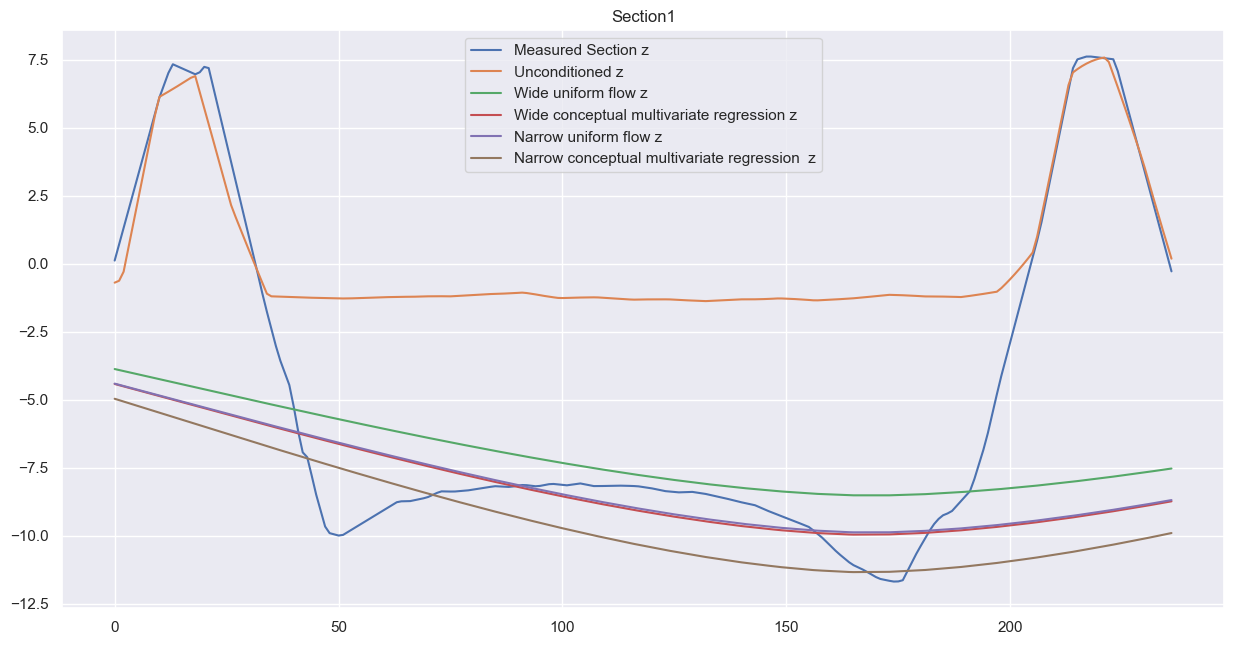

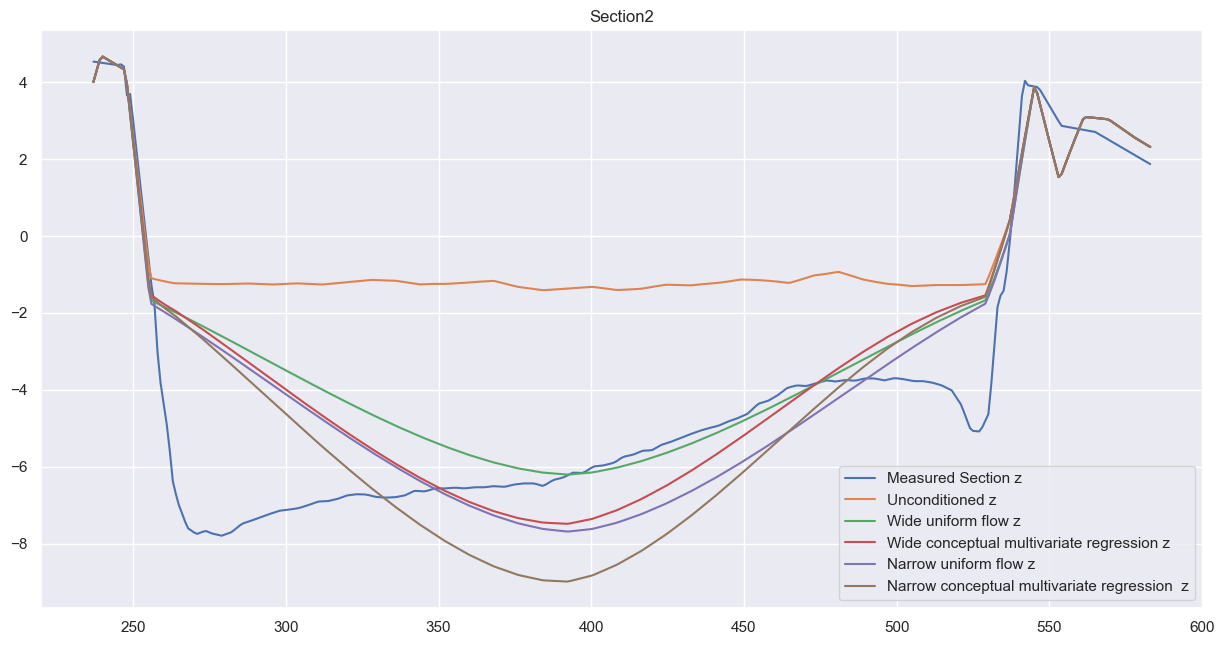

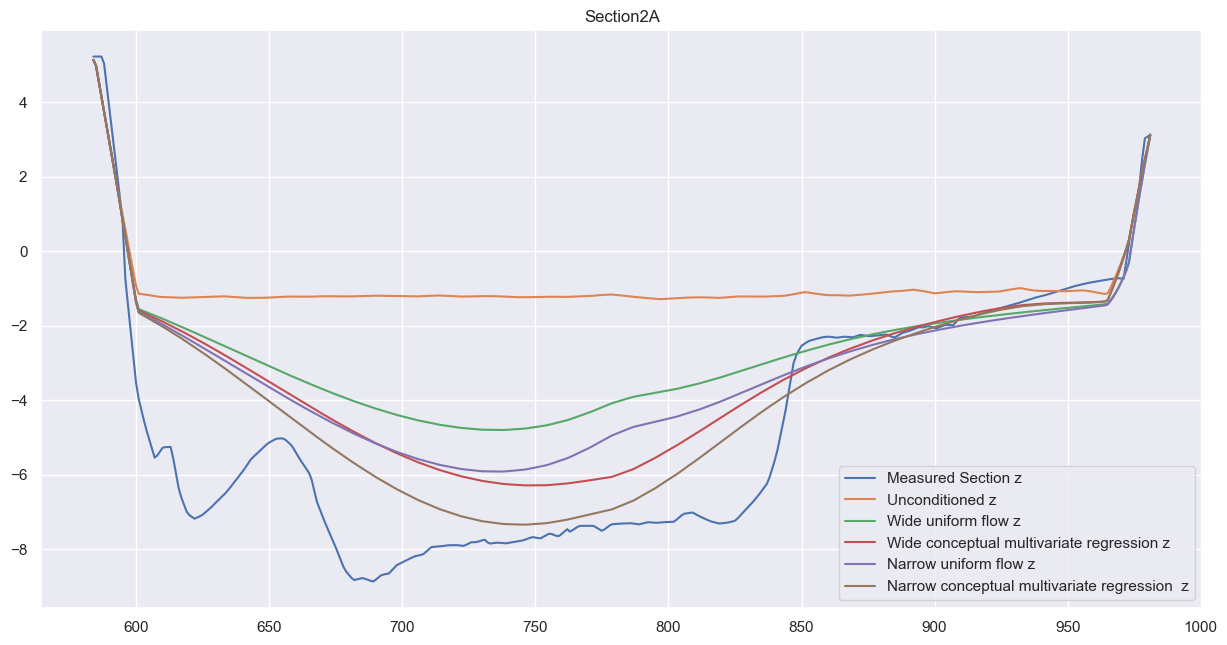

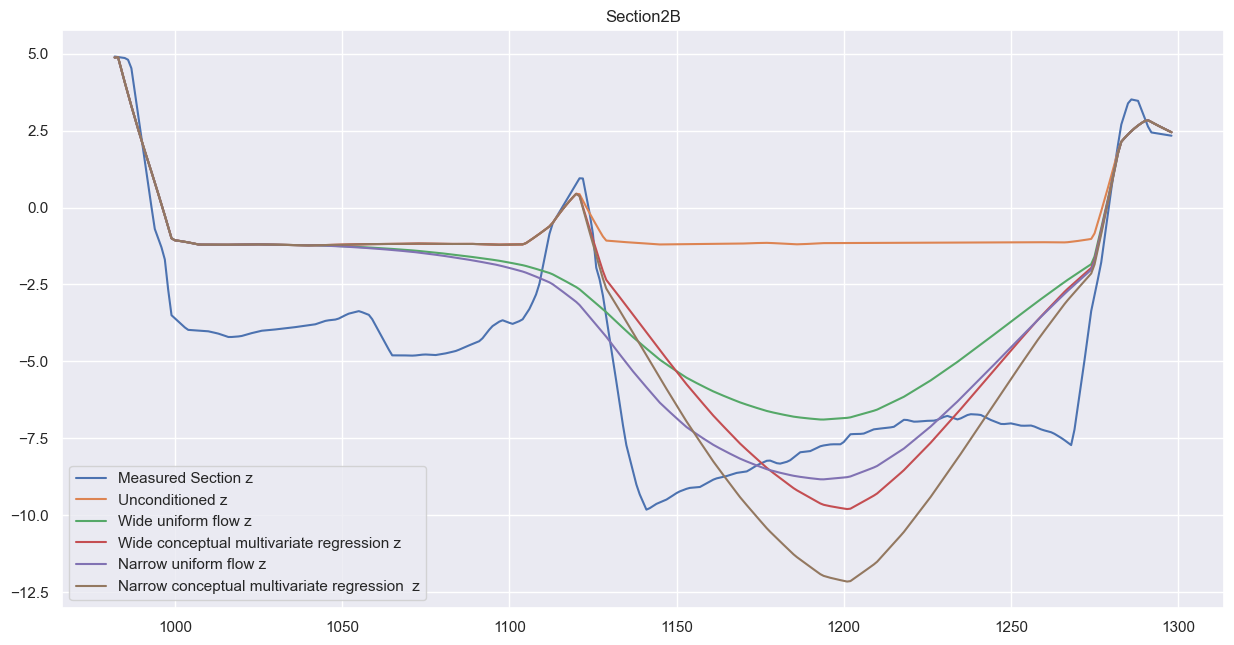

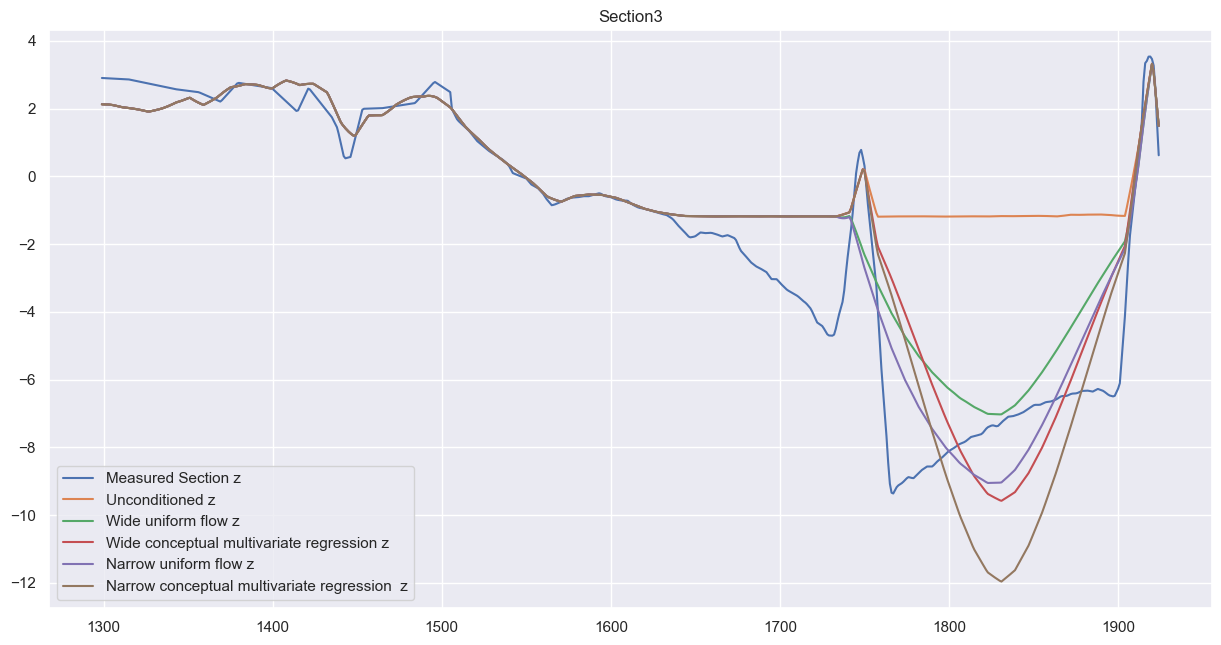

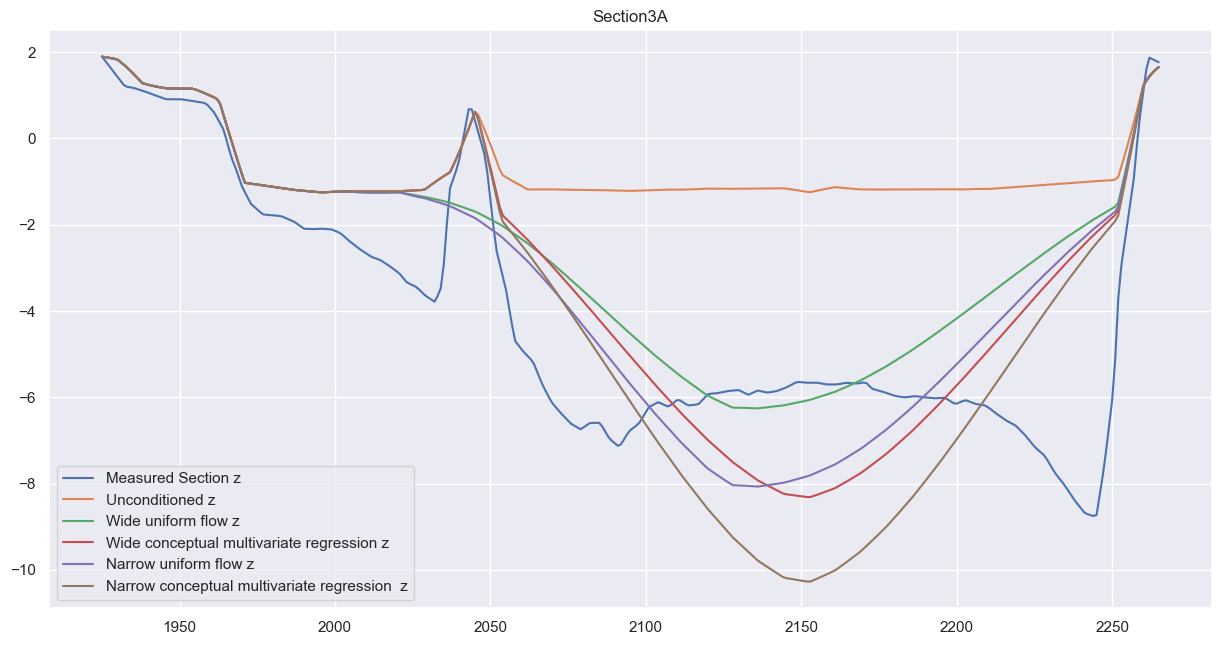

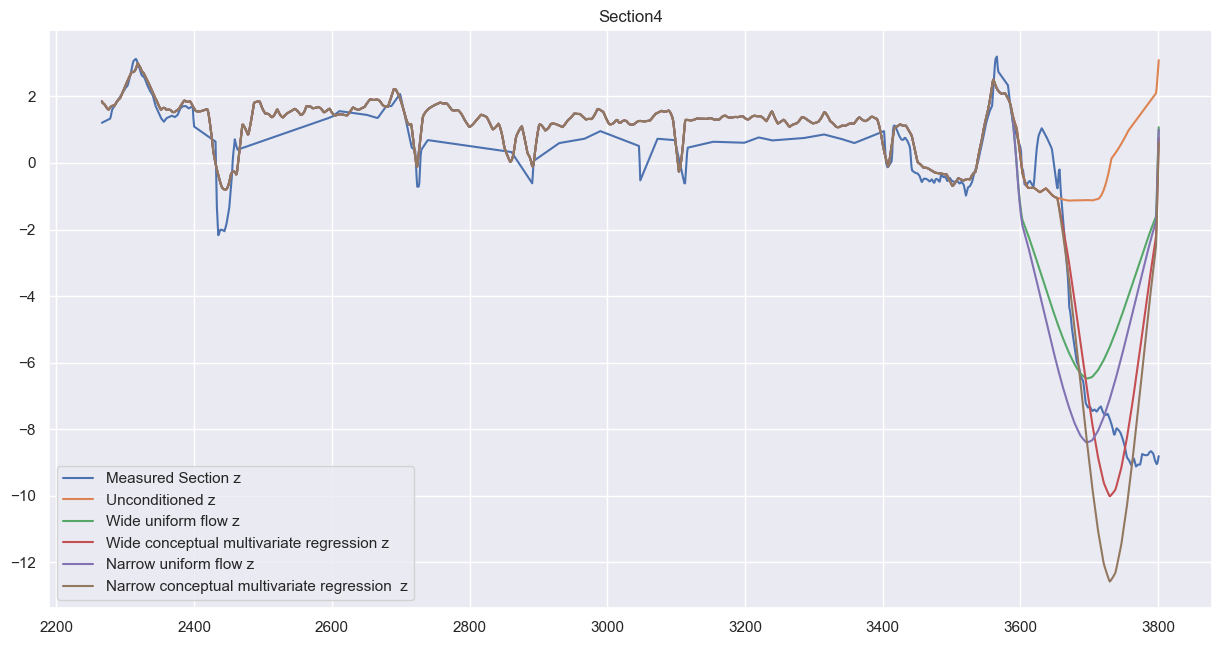

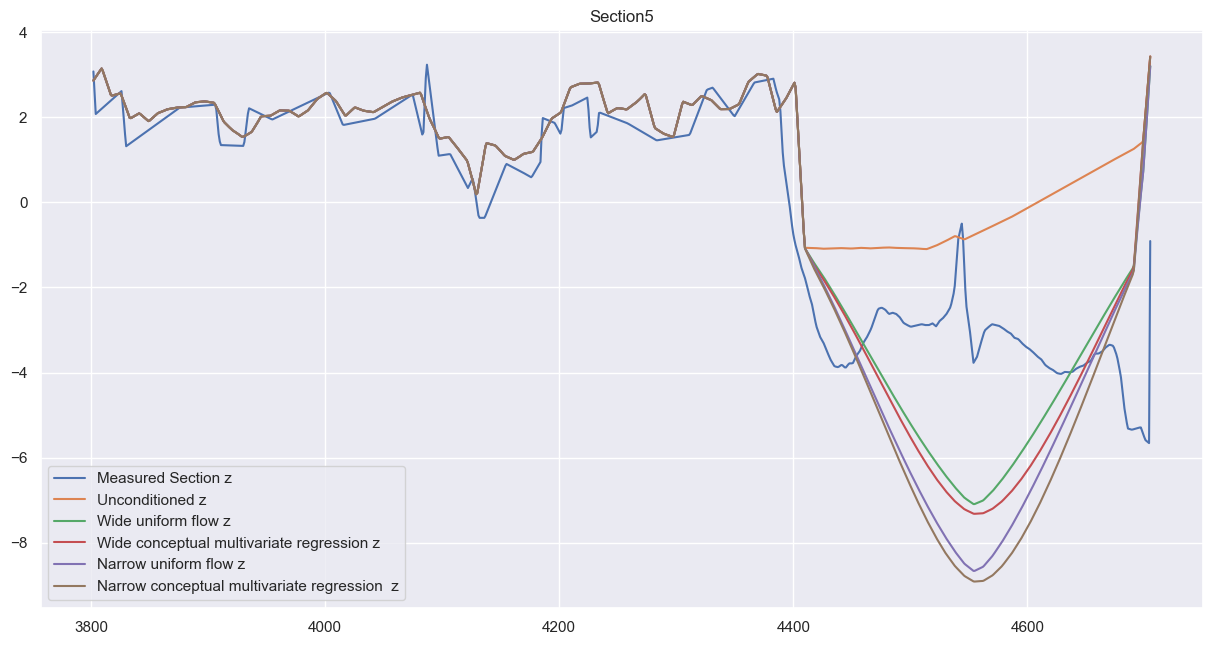

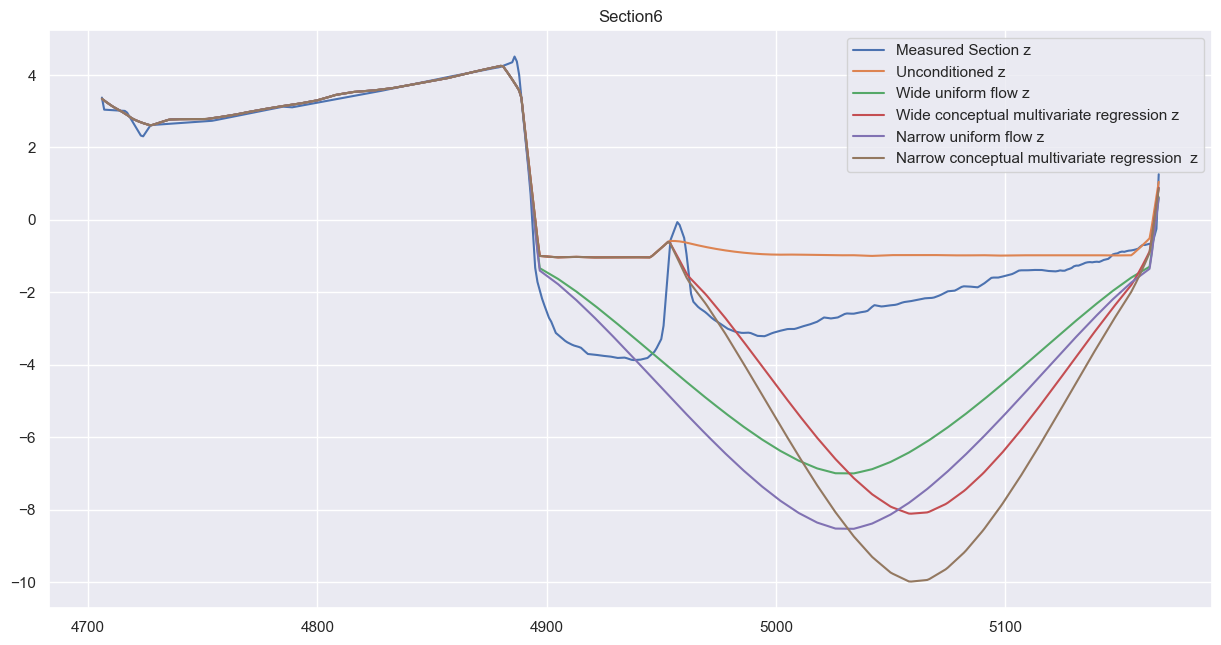

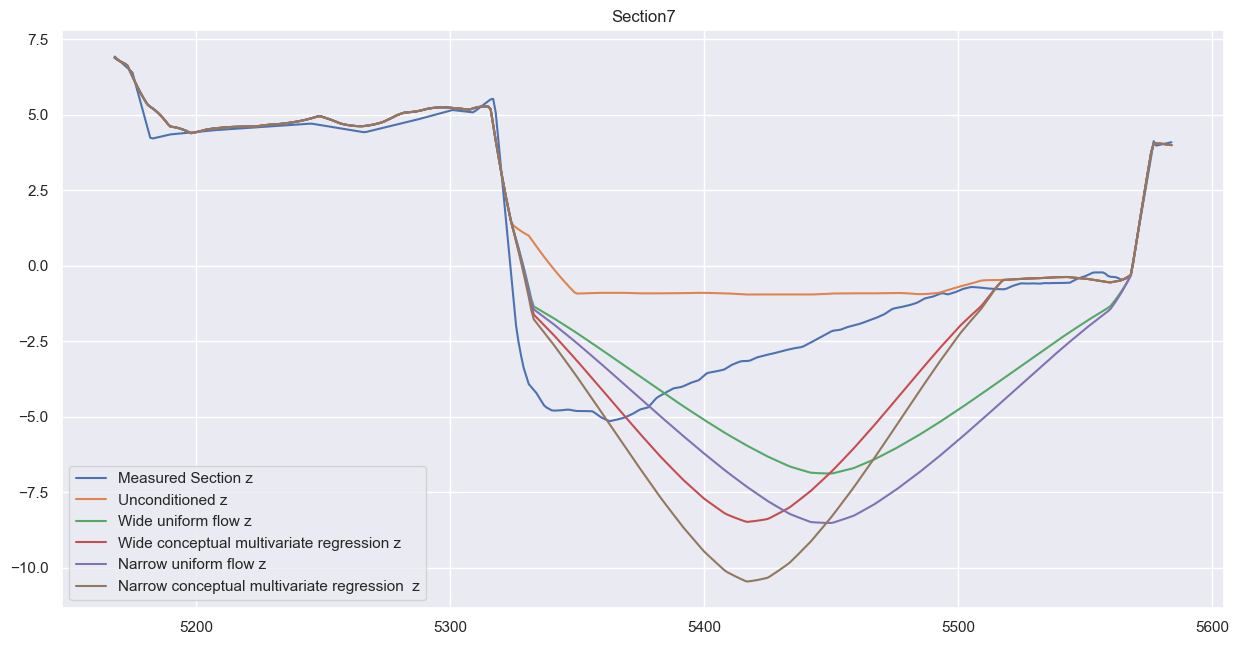

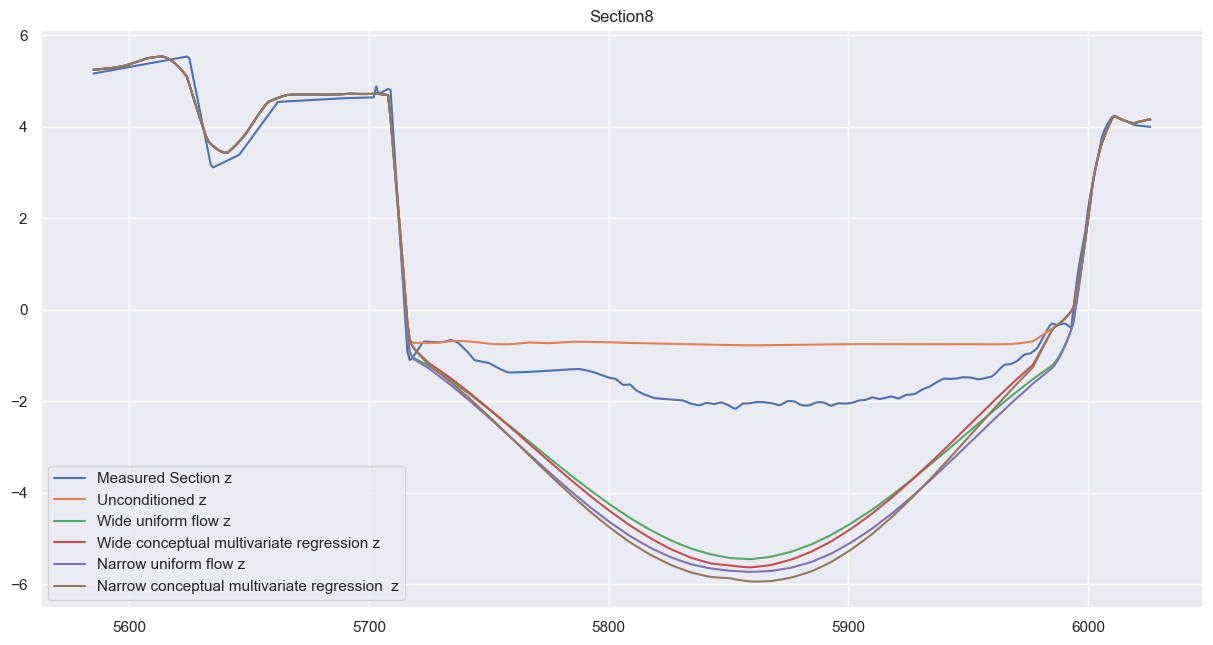

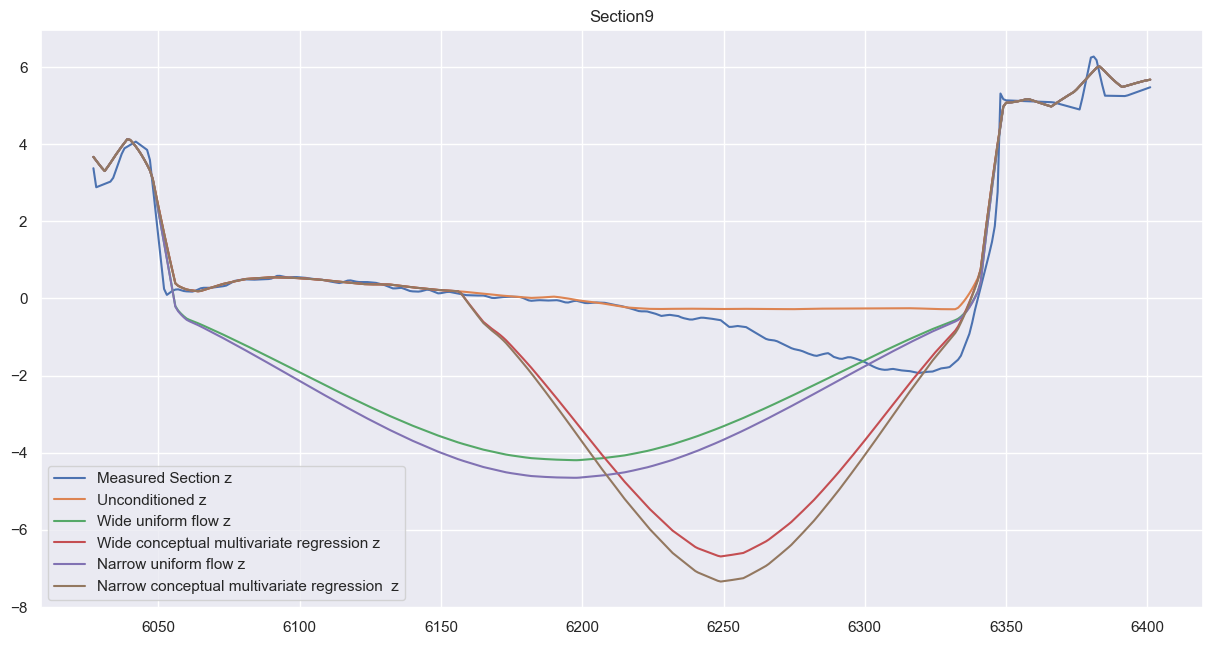

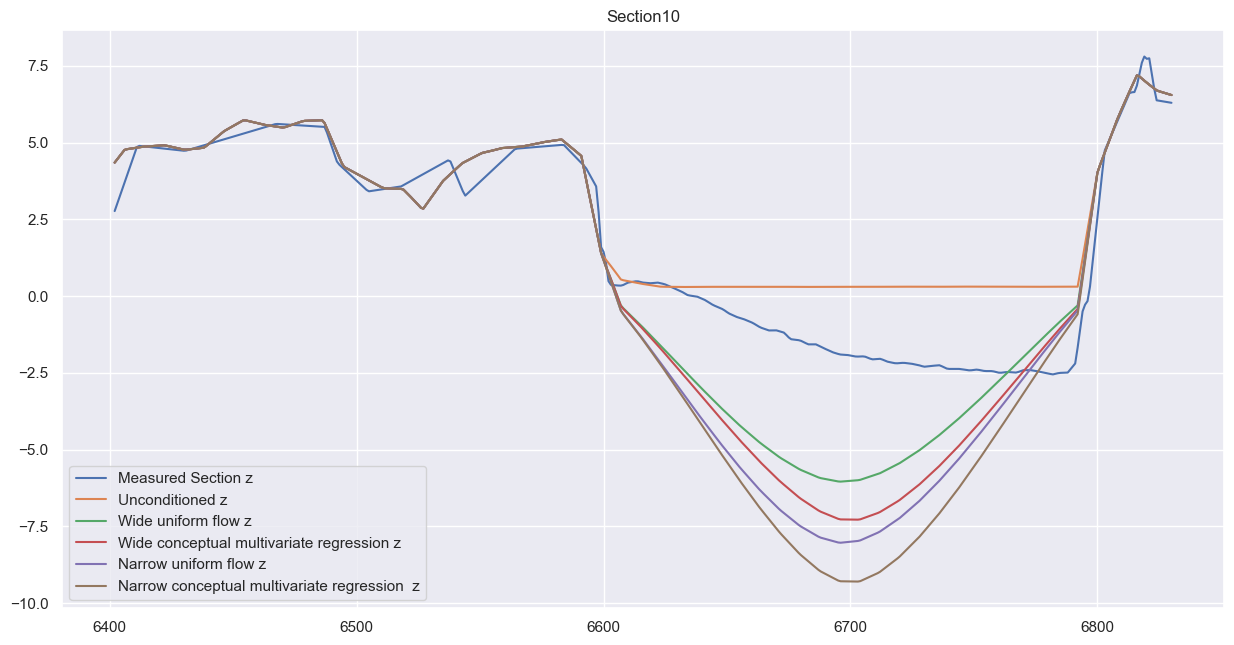

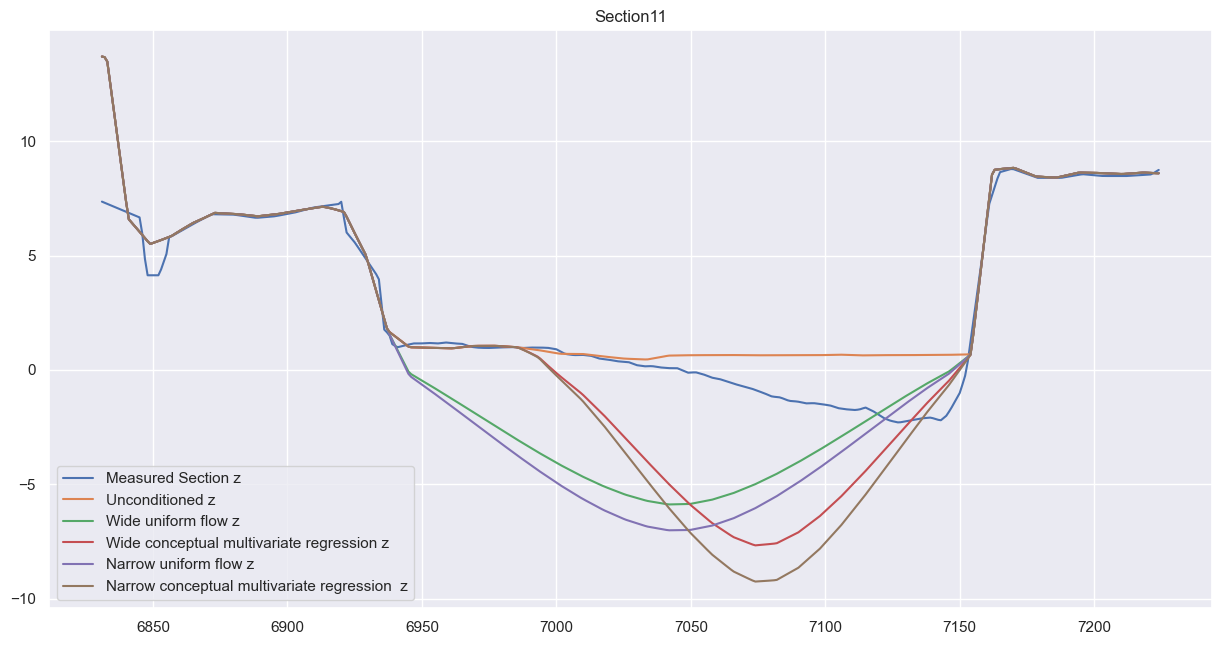

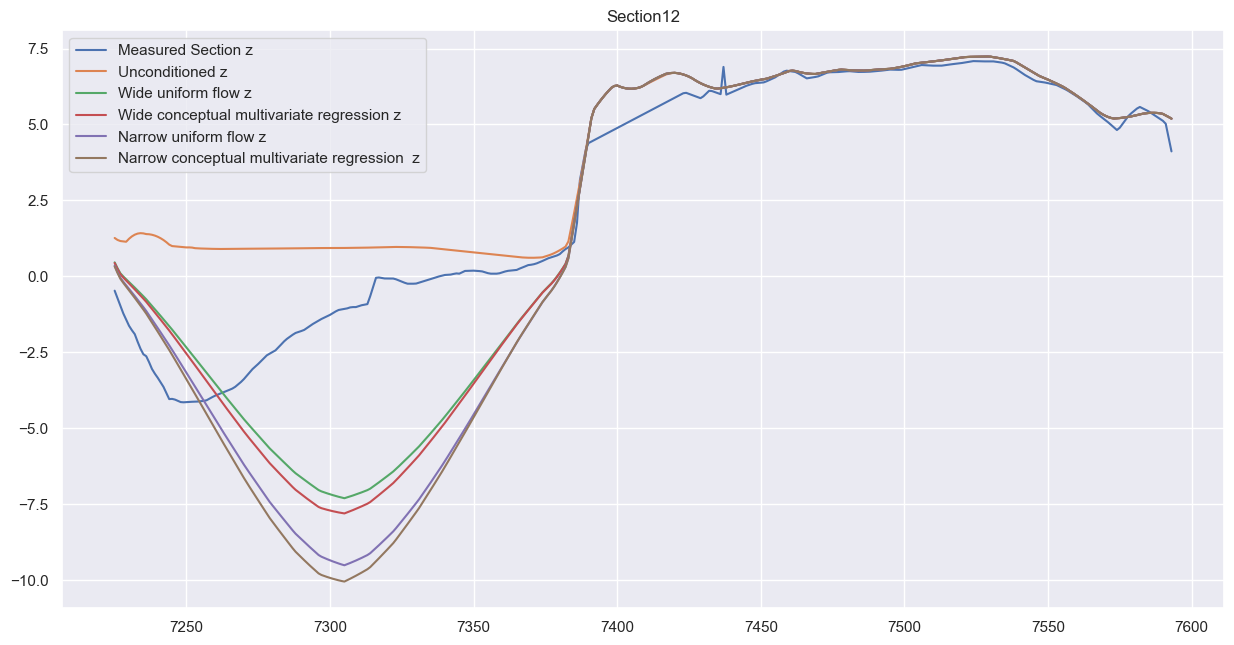

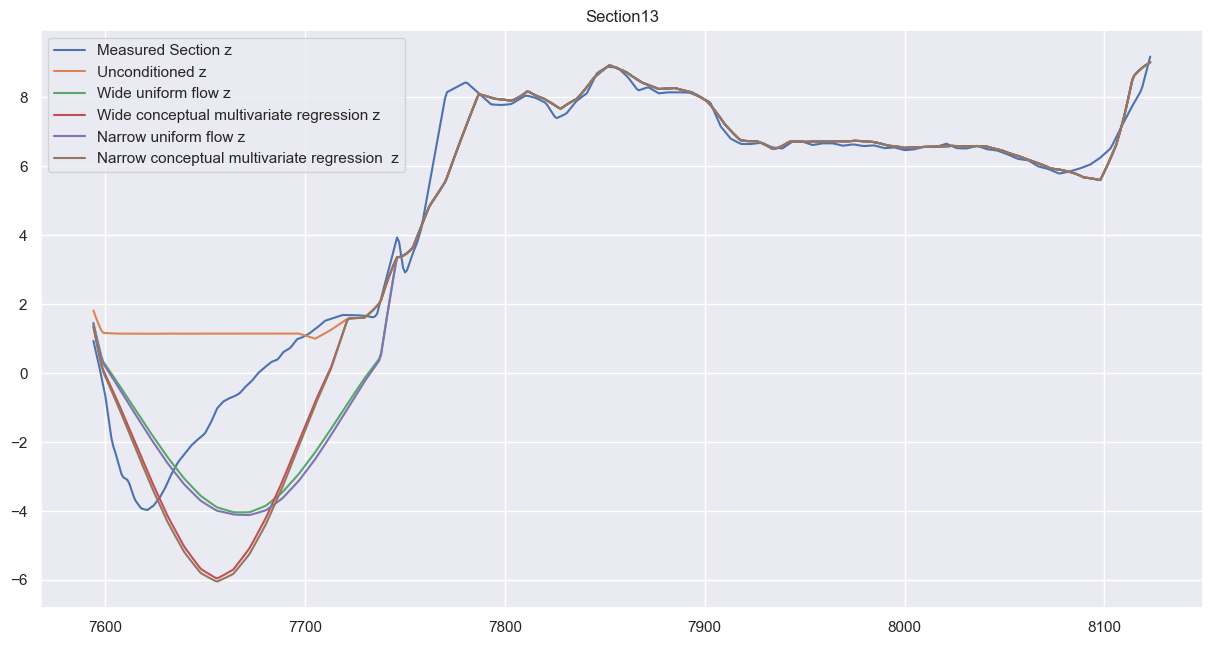

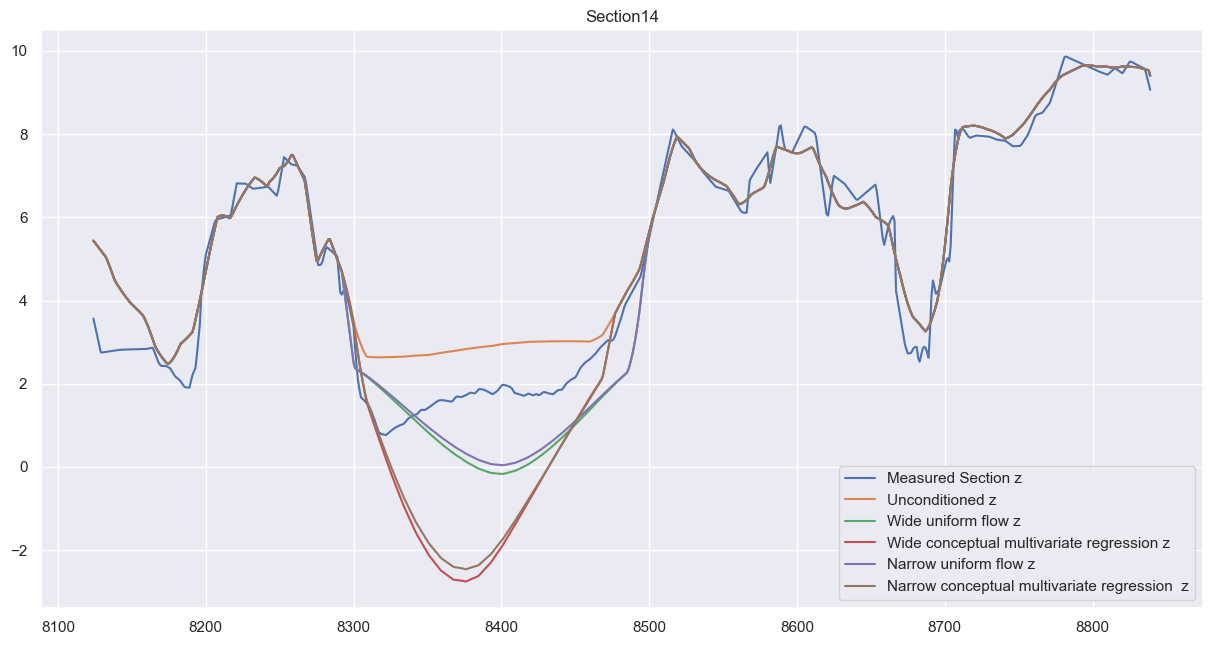

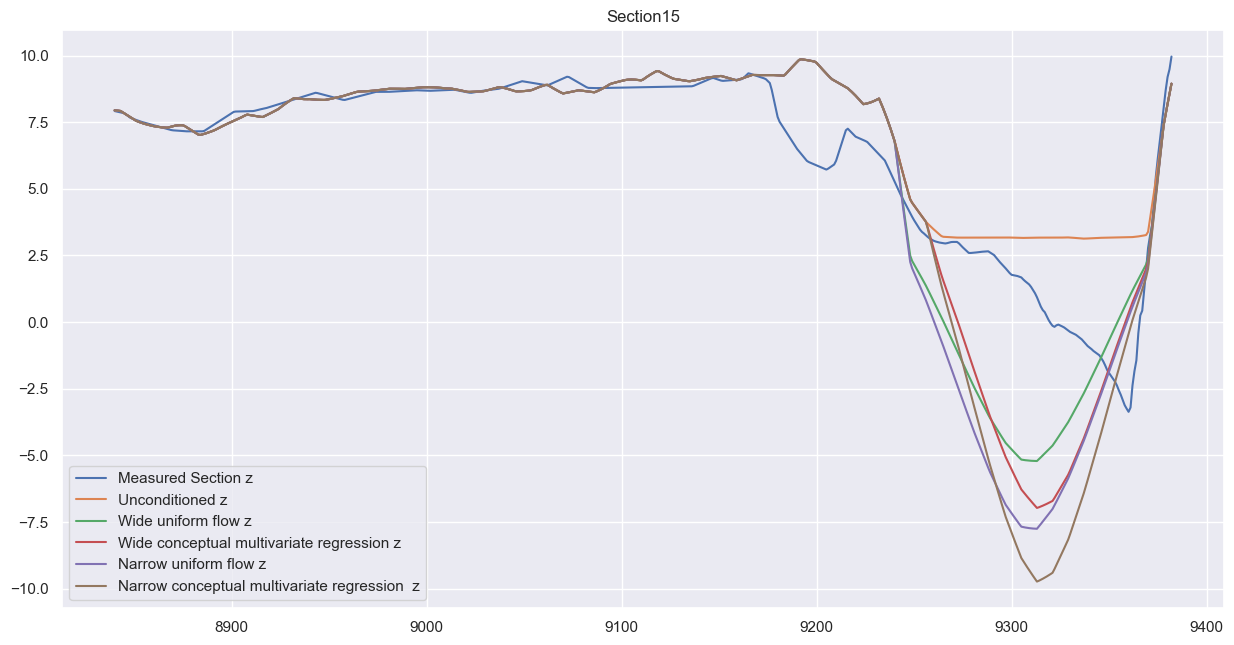

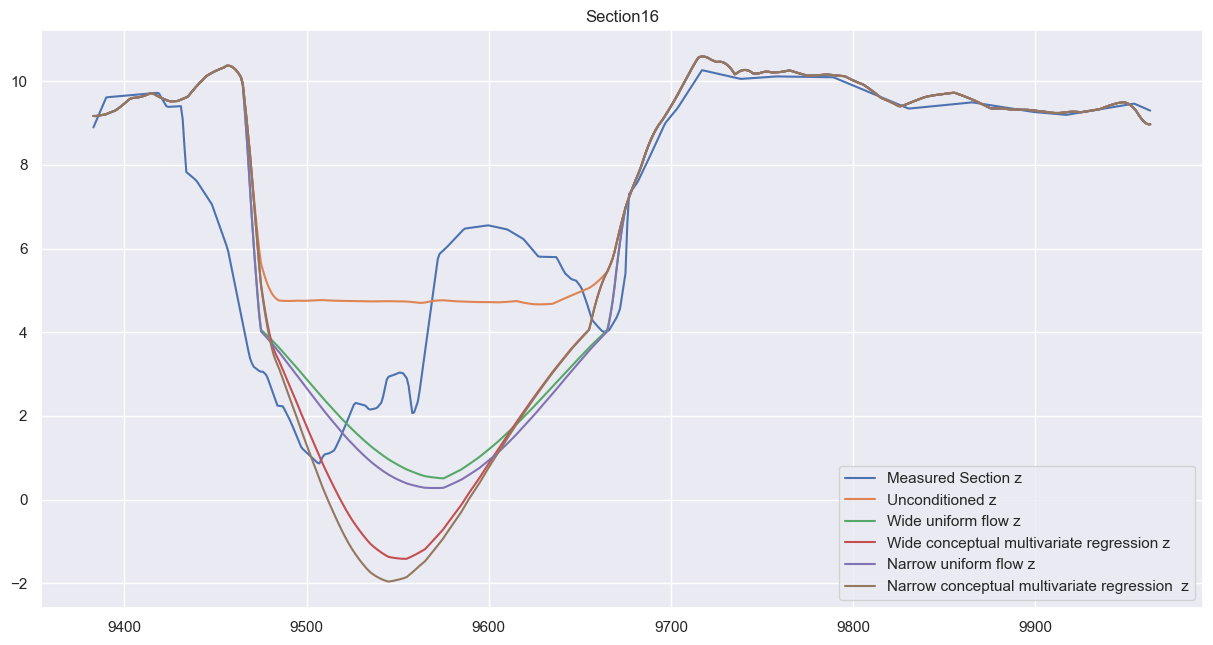

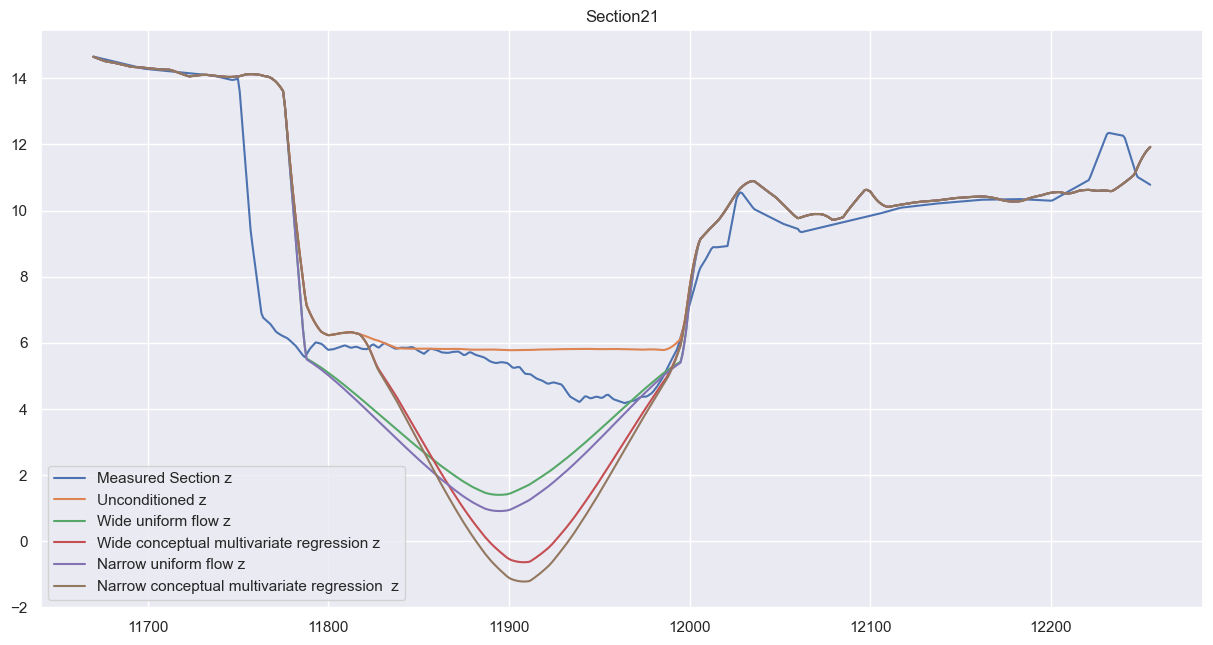

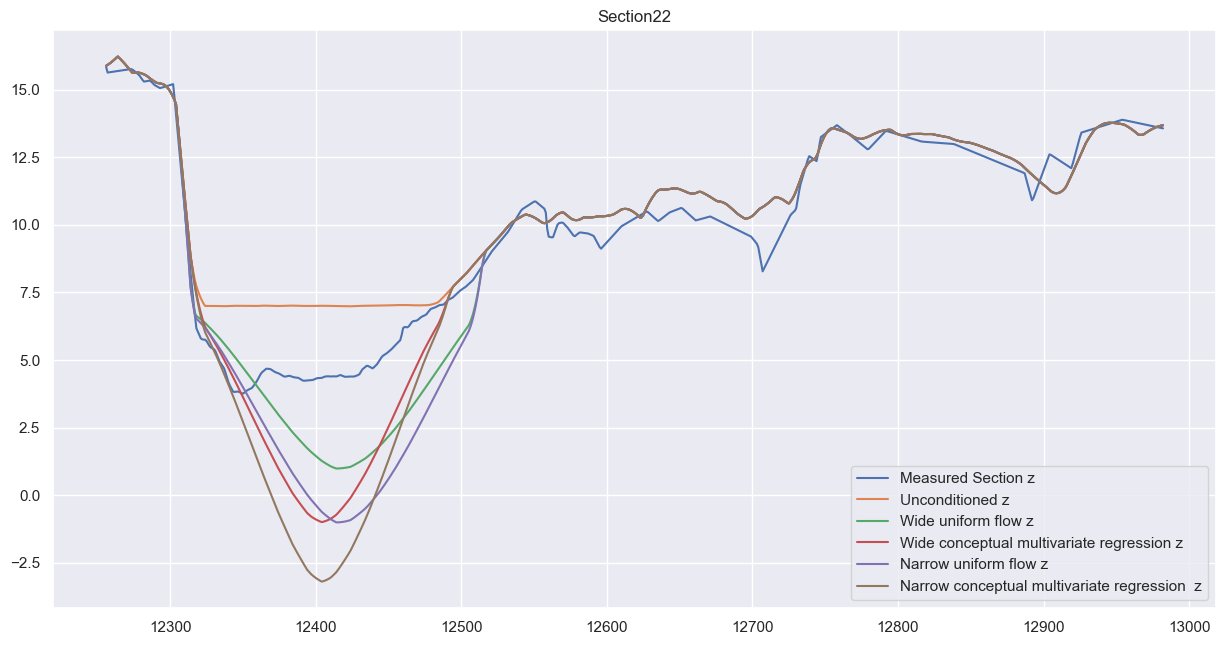

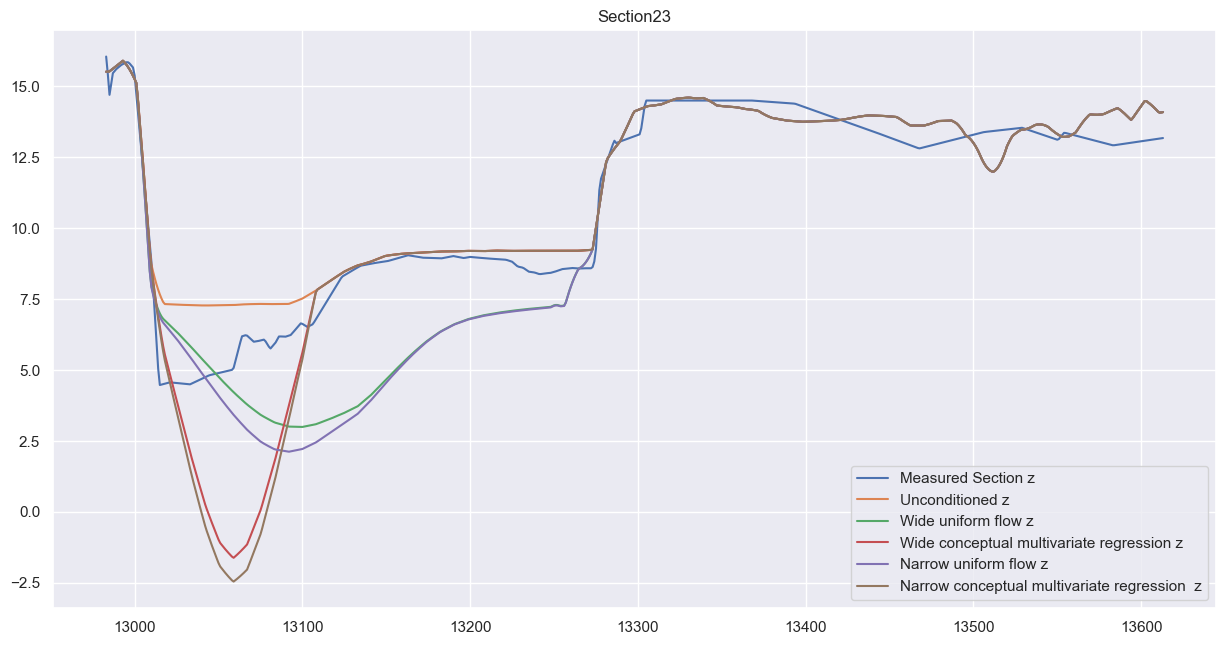

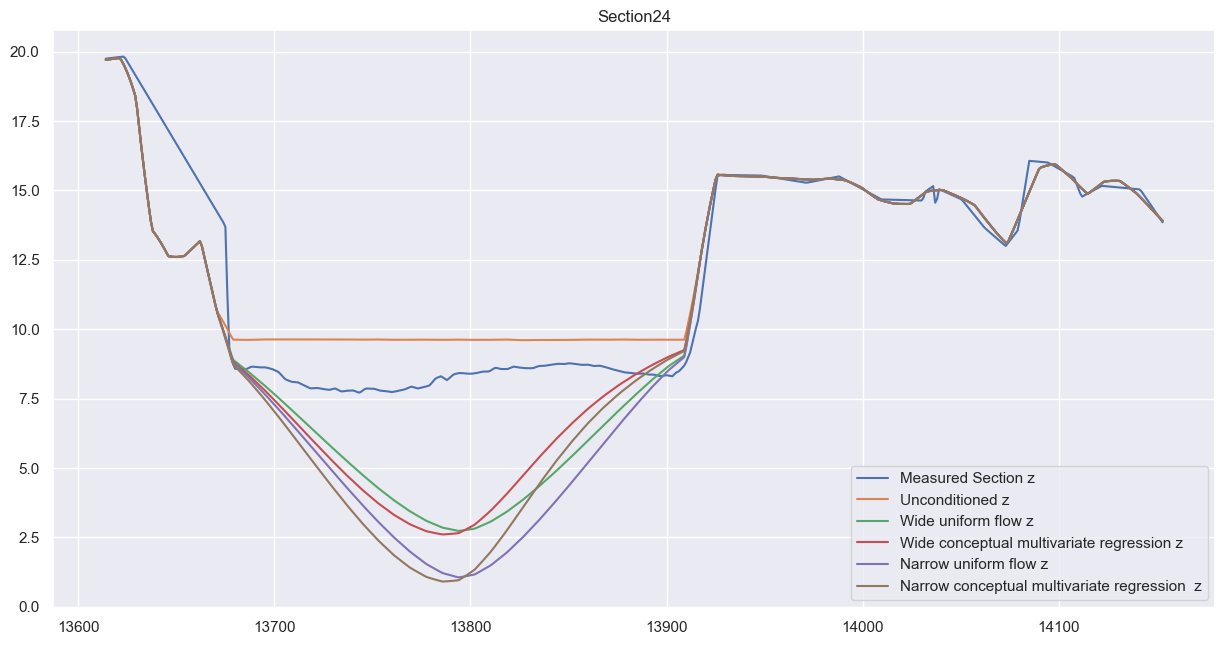

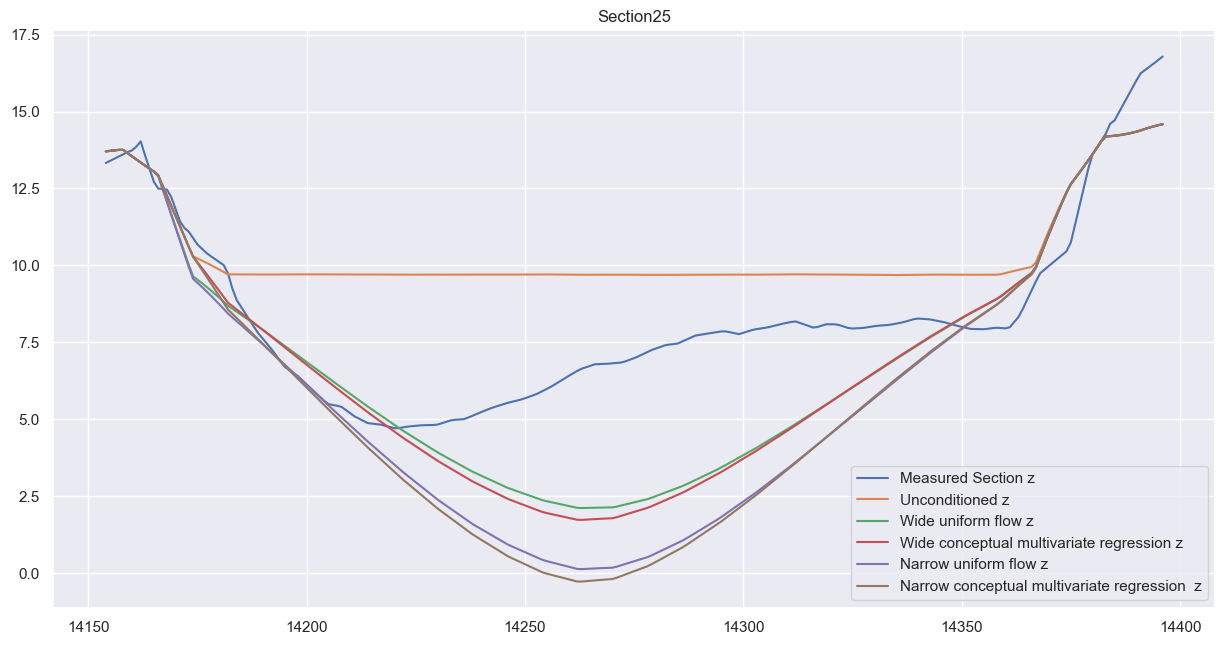

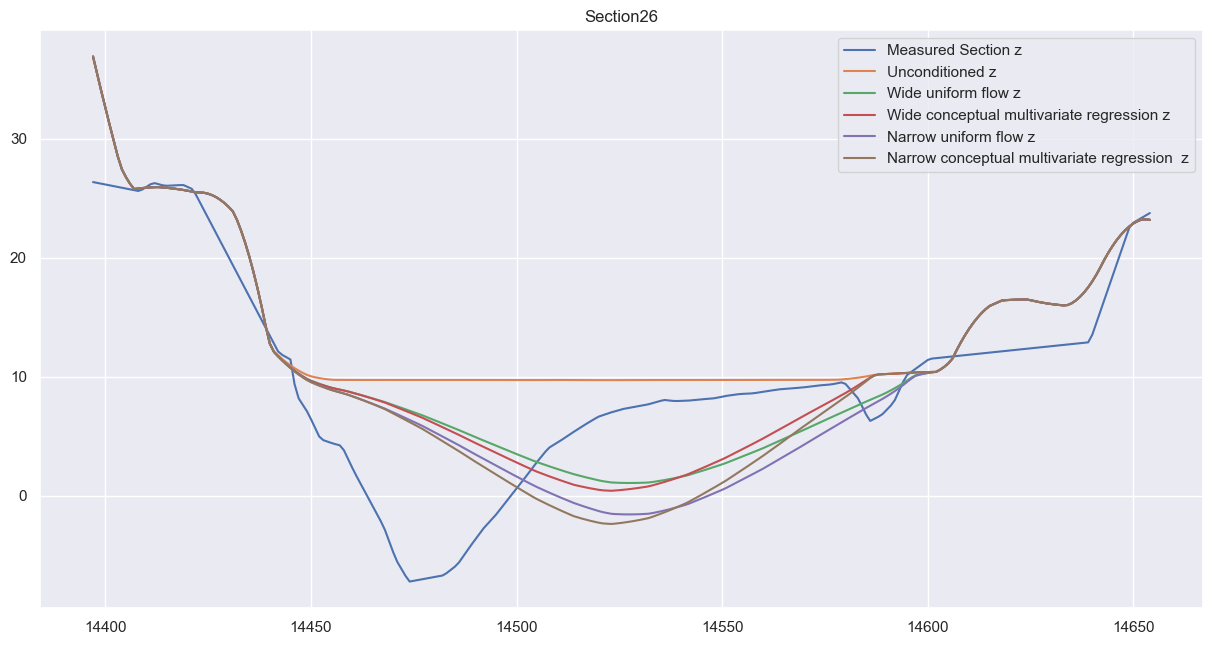

In [57]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in ordered_measured_sections:
    figure = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=section)
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"{section}.png")

C:\Users\pearsonra\Anaconda3\envs\raster\Lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


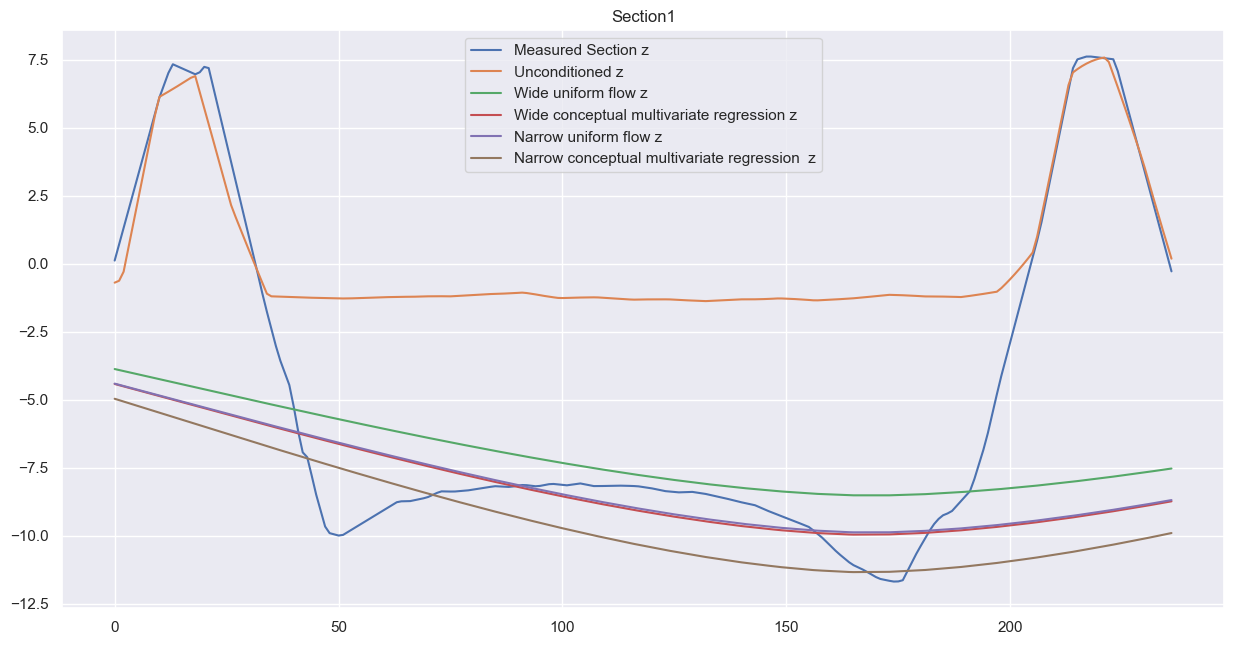

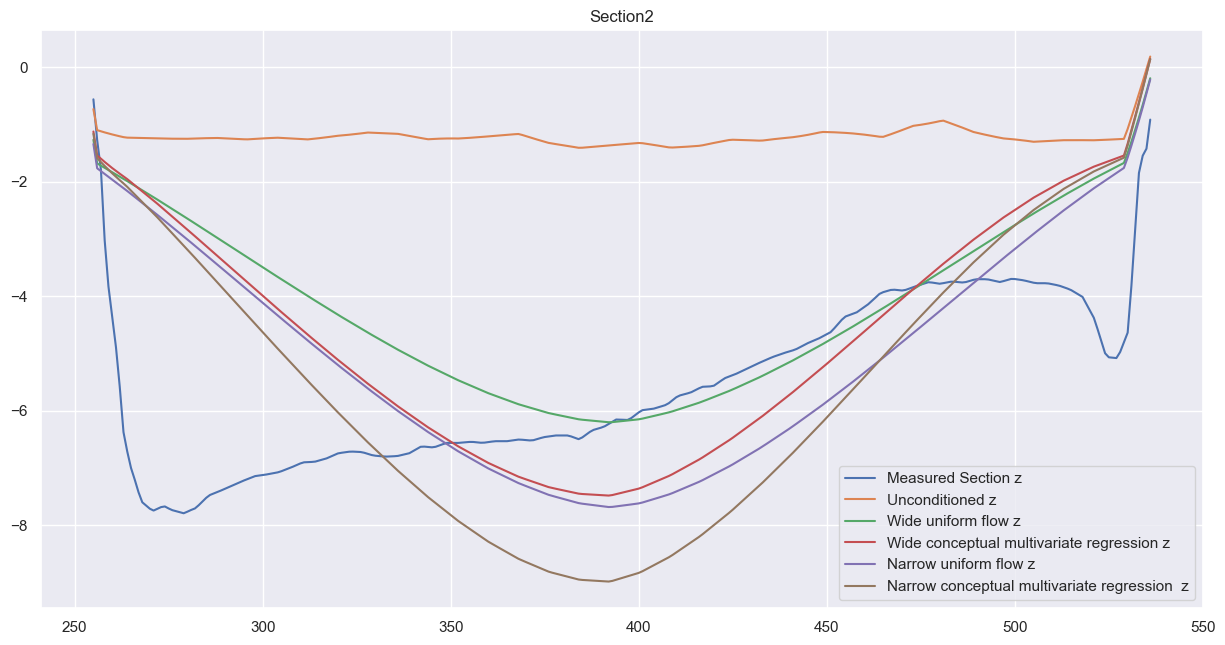

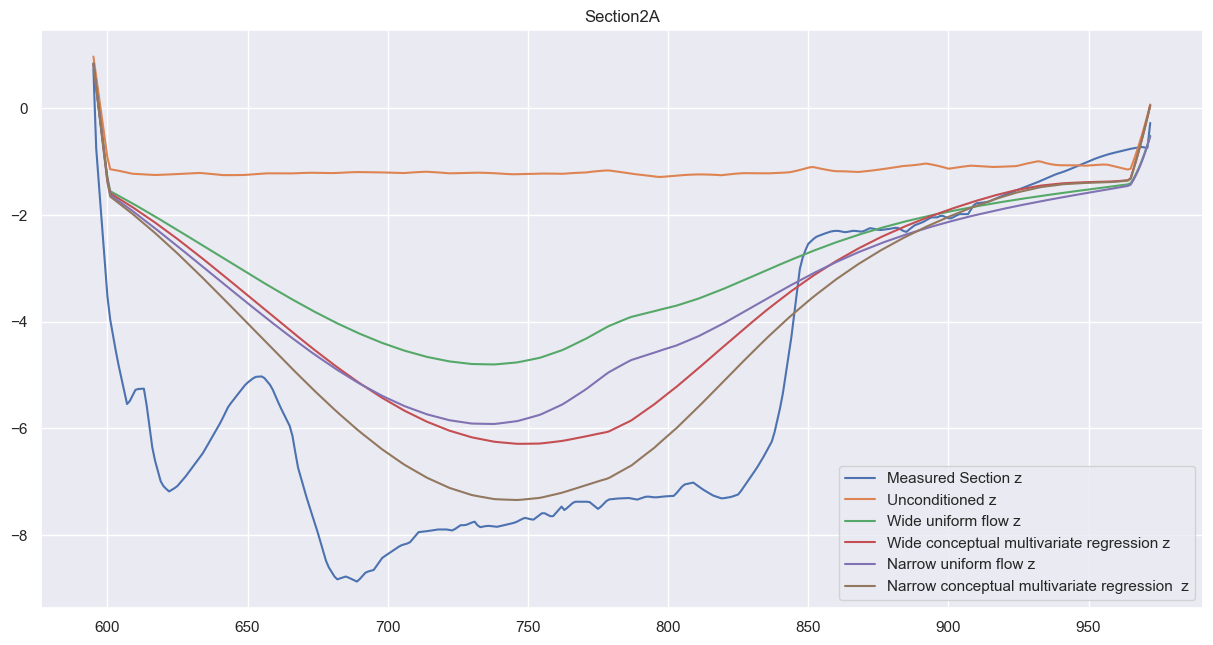

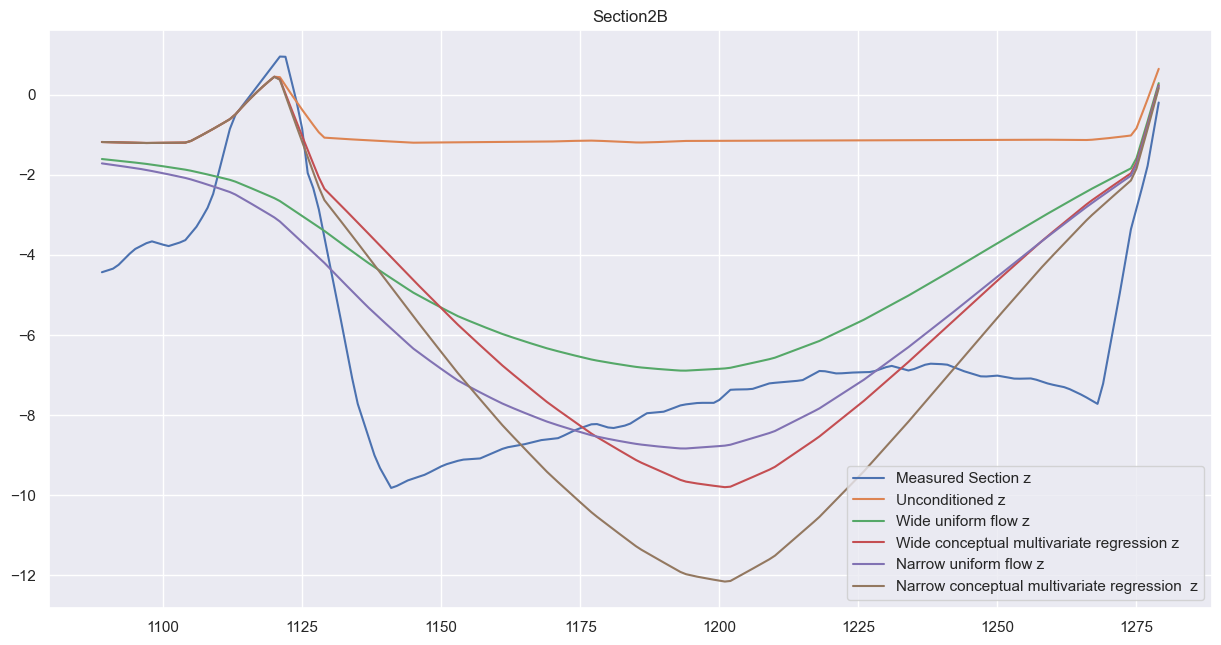

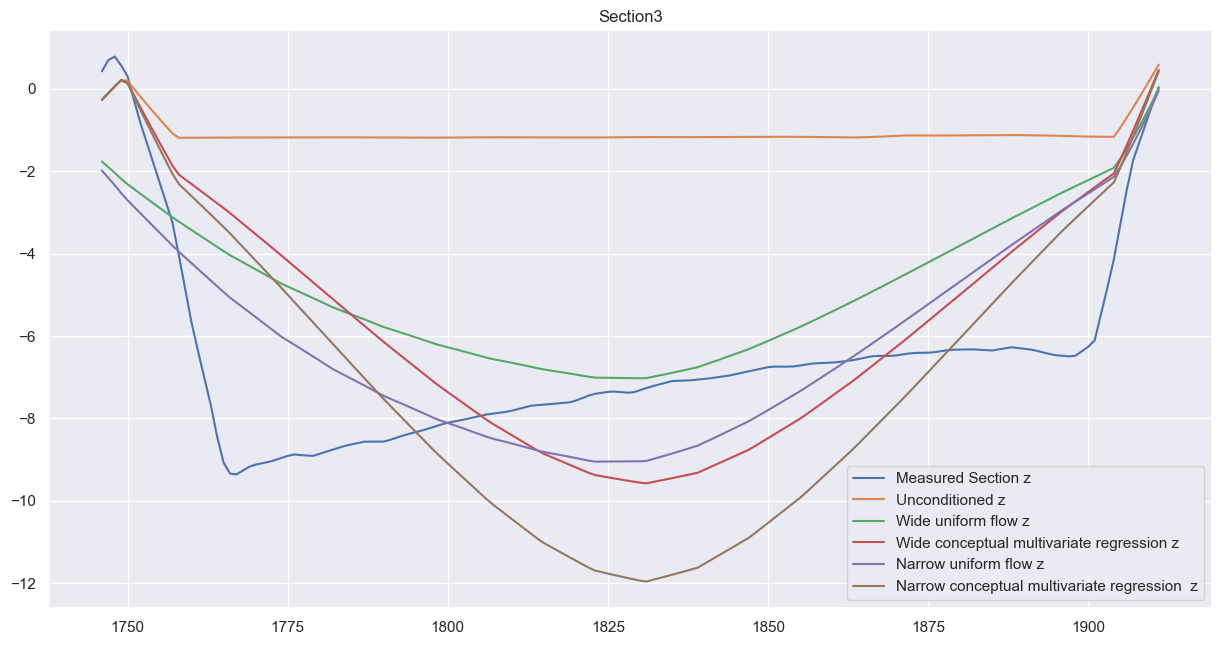

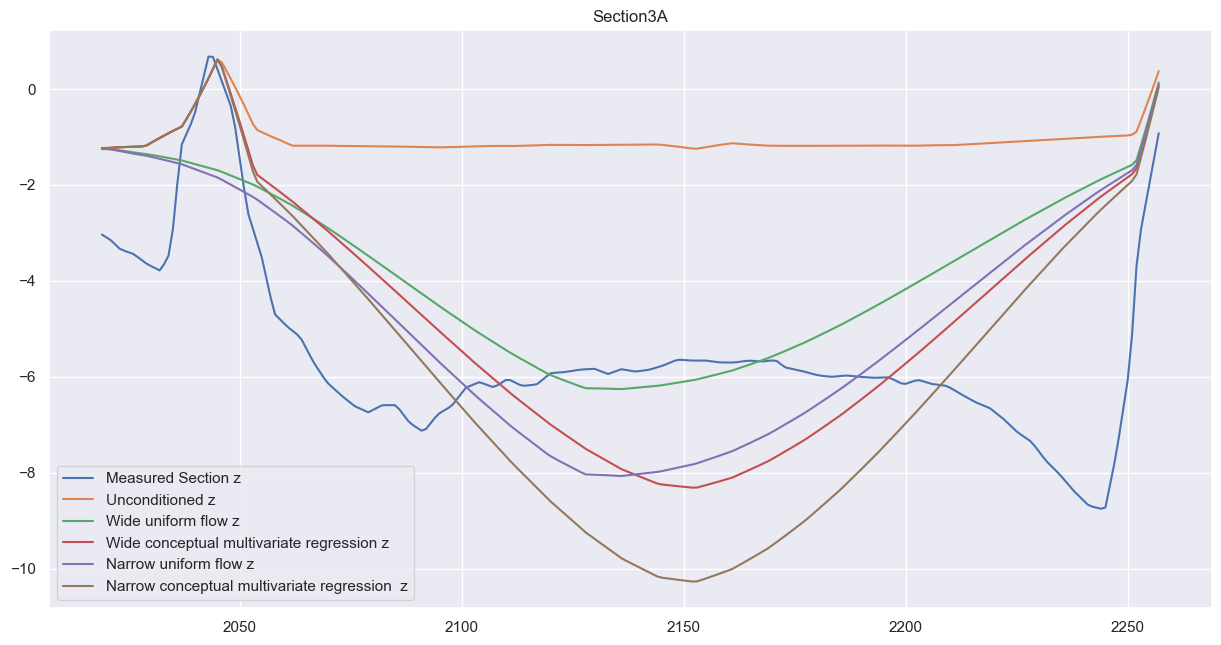

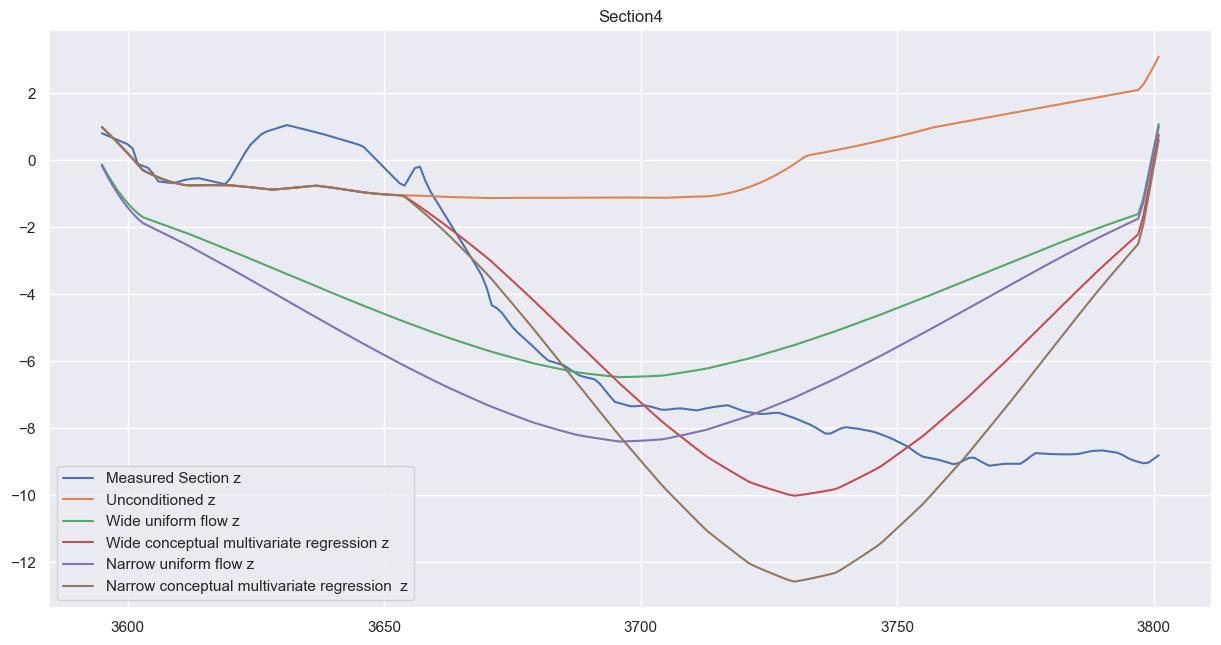

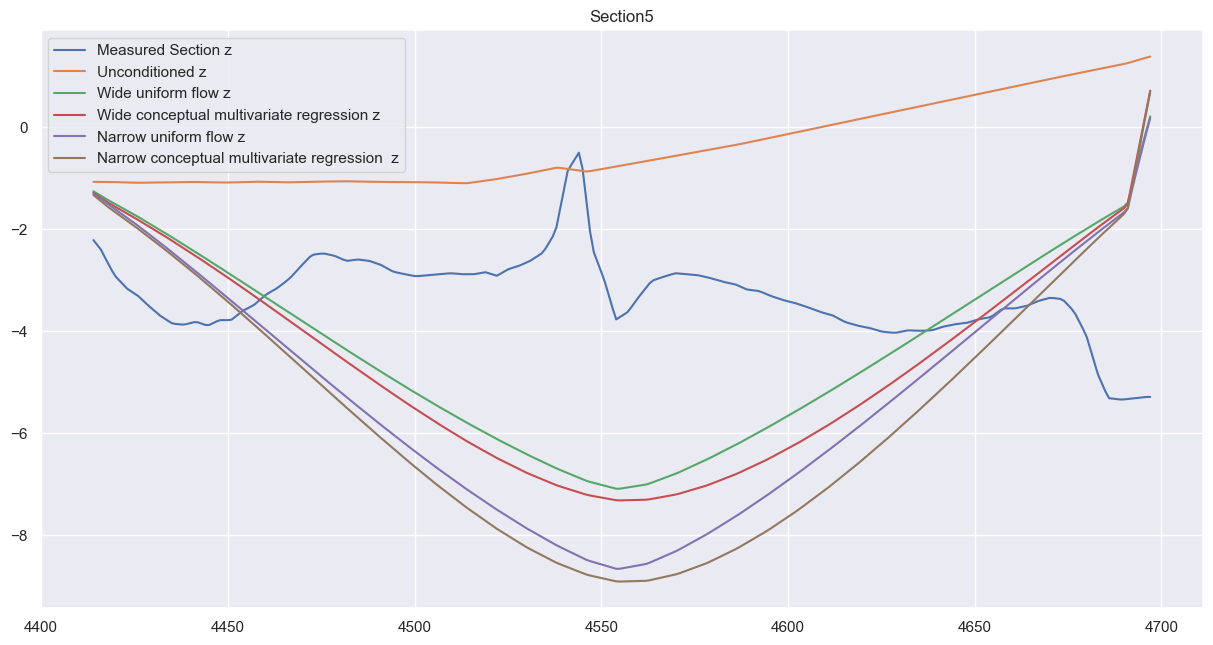

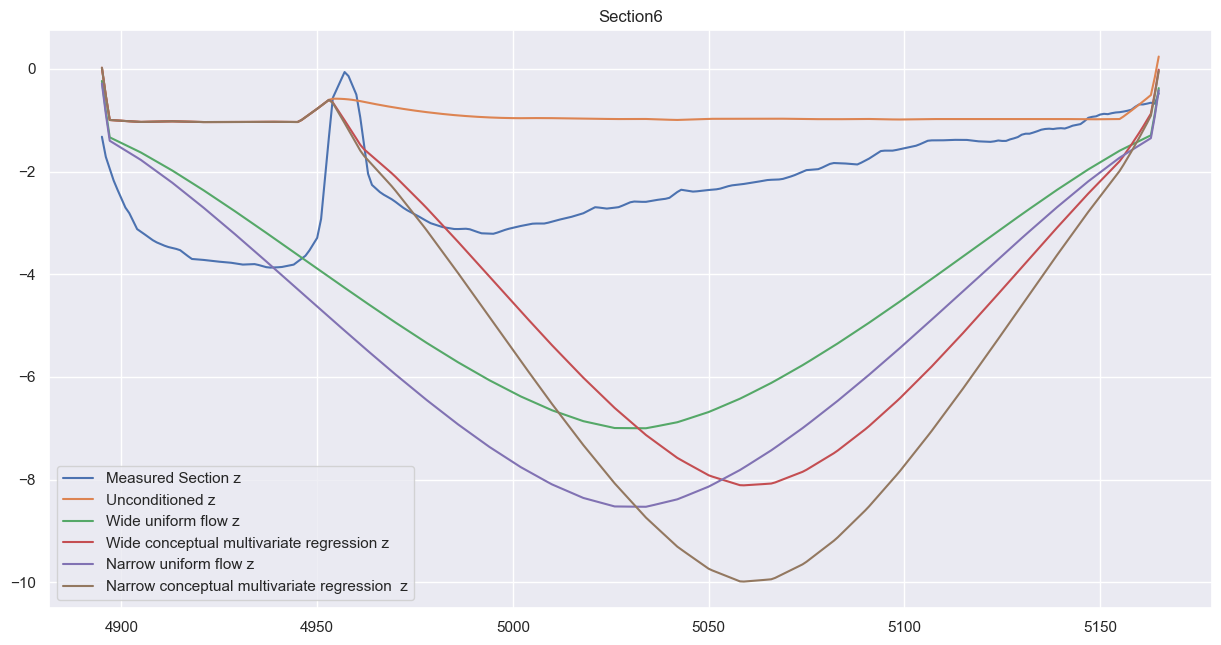

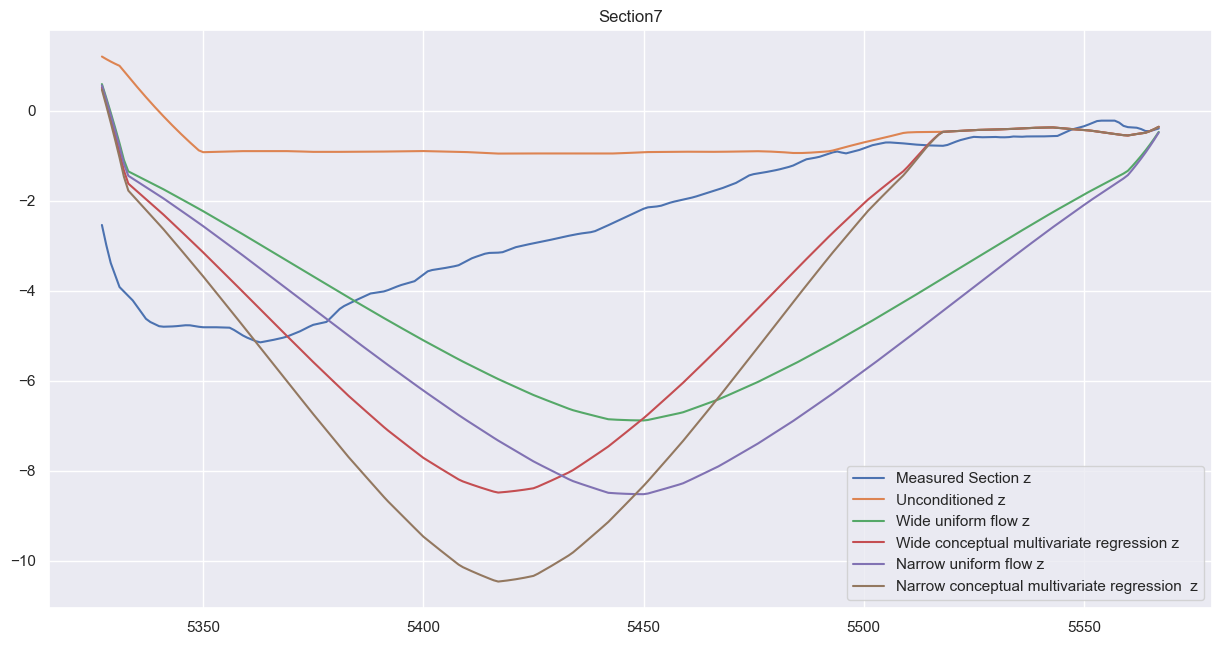

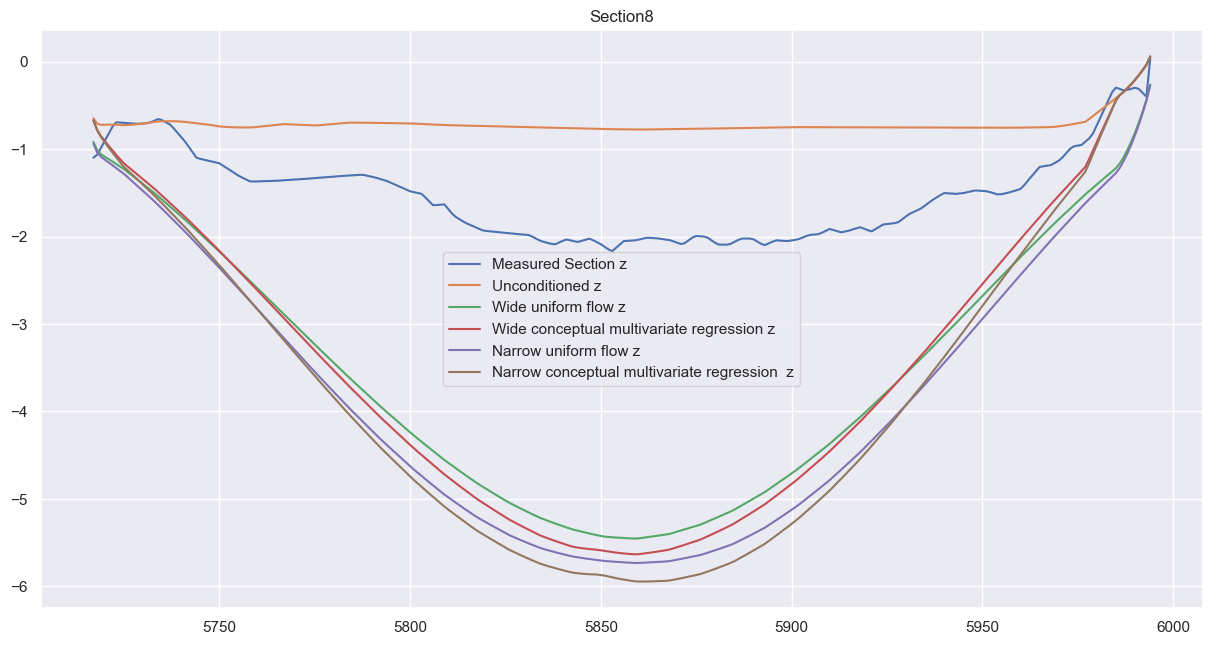

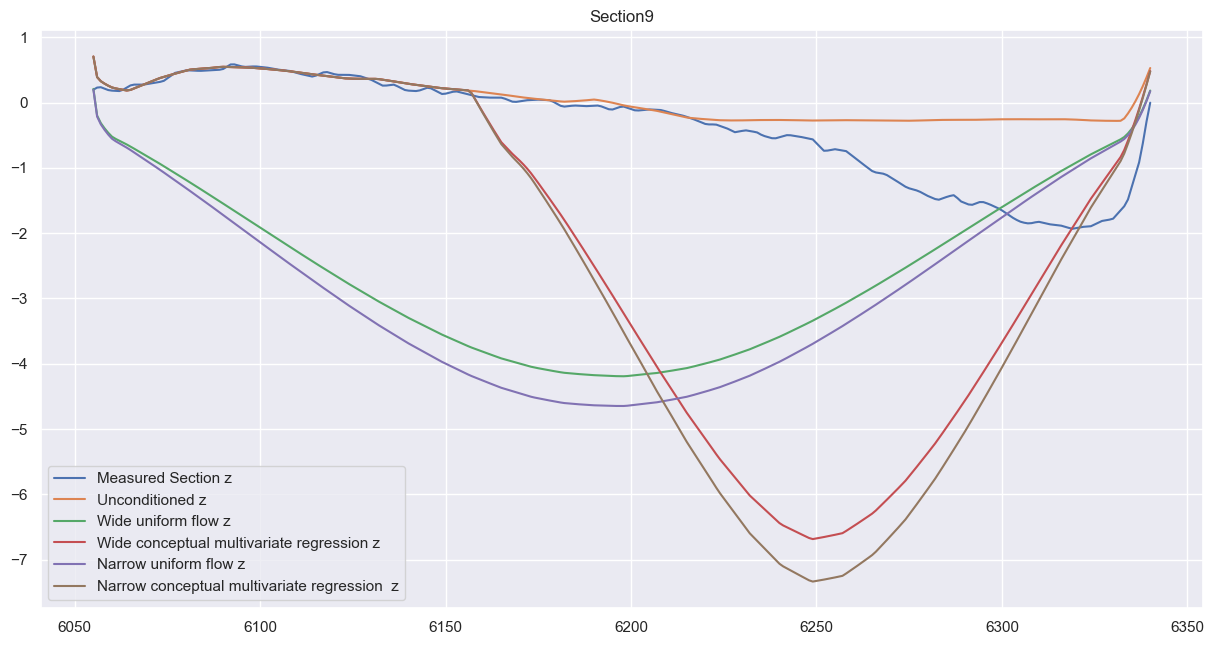

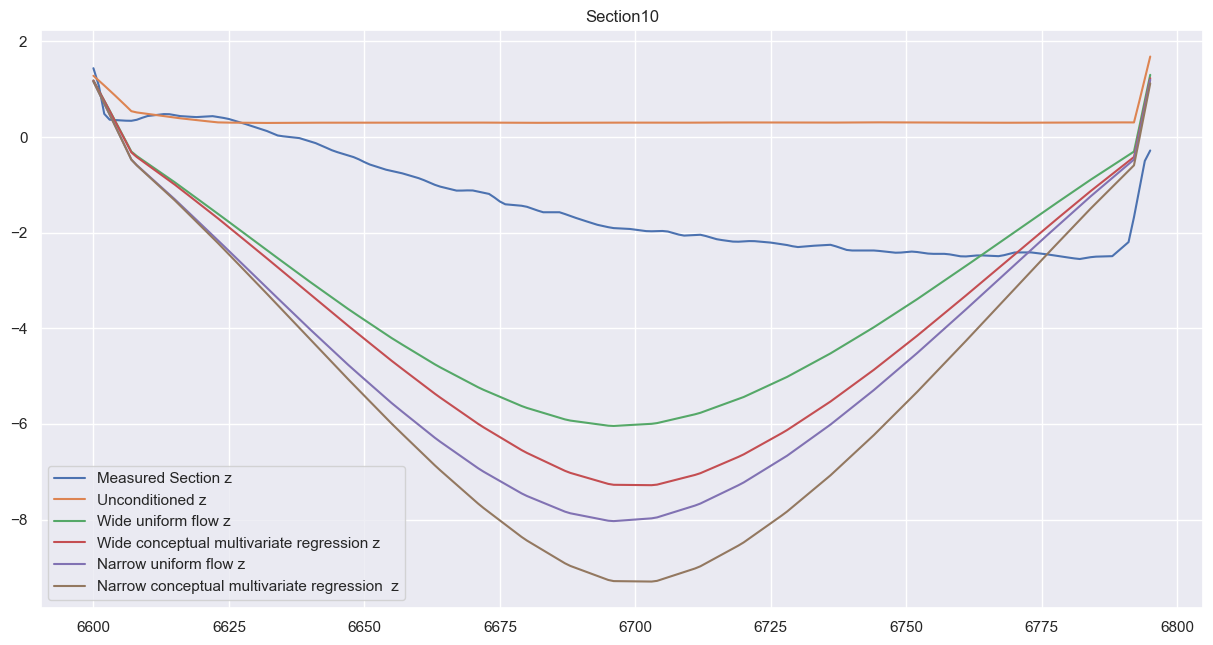

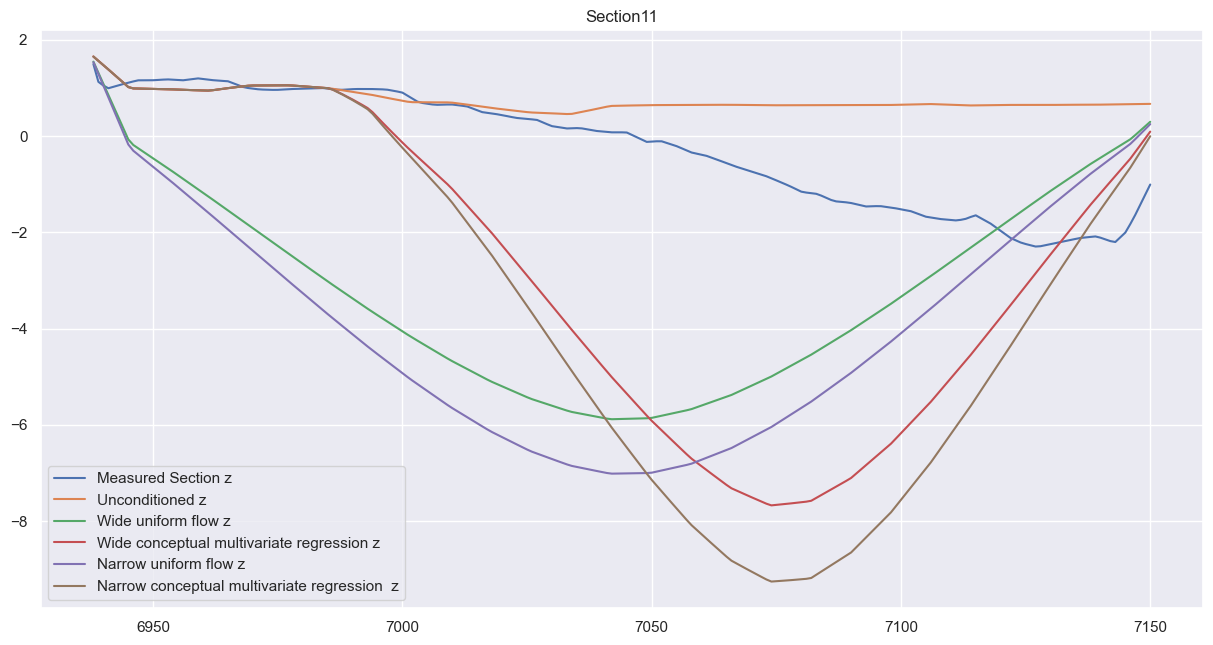

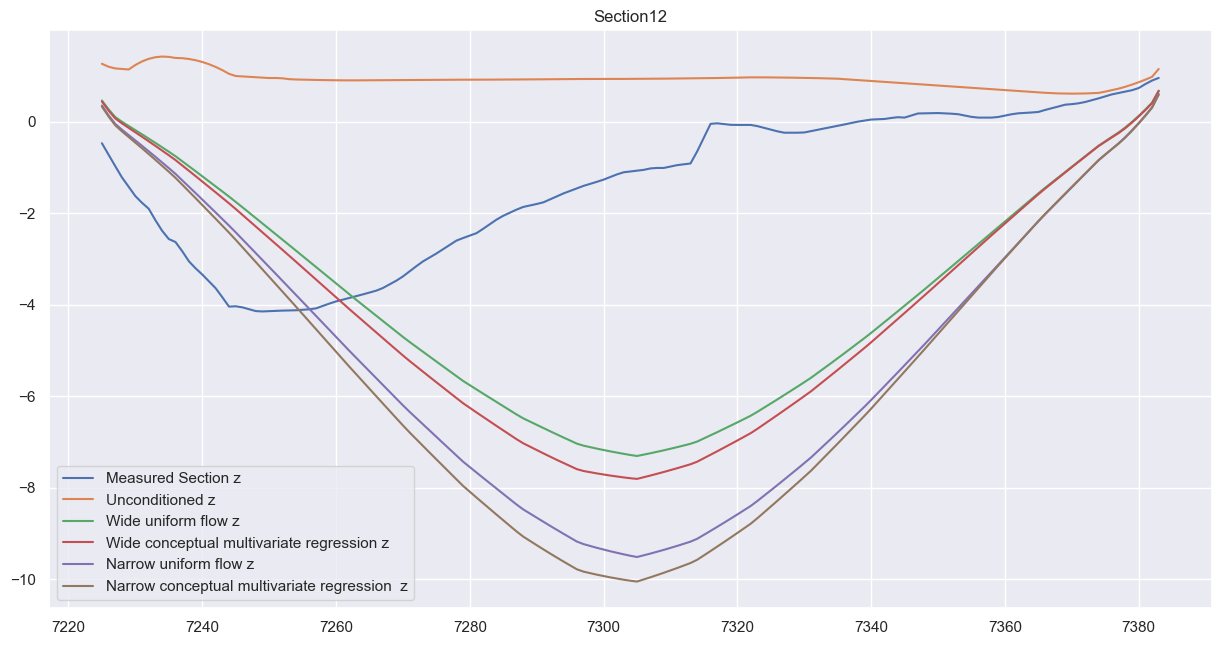

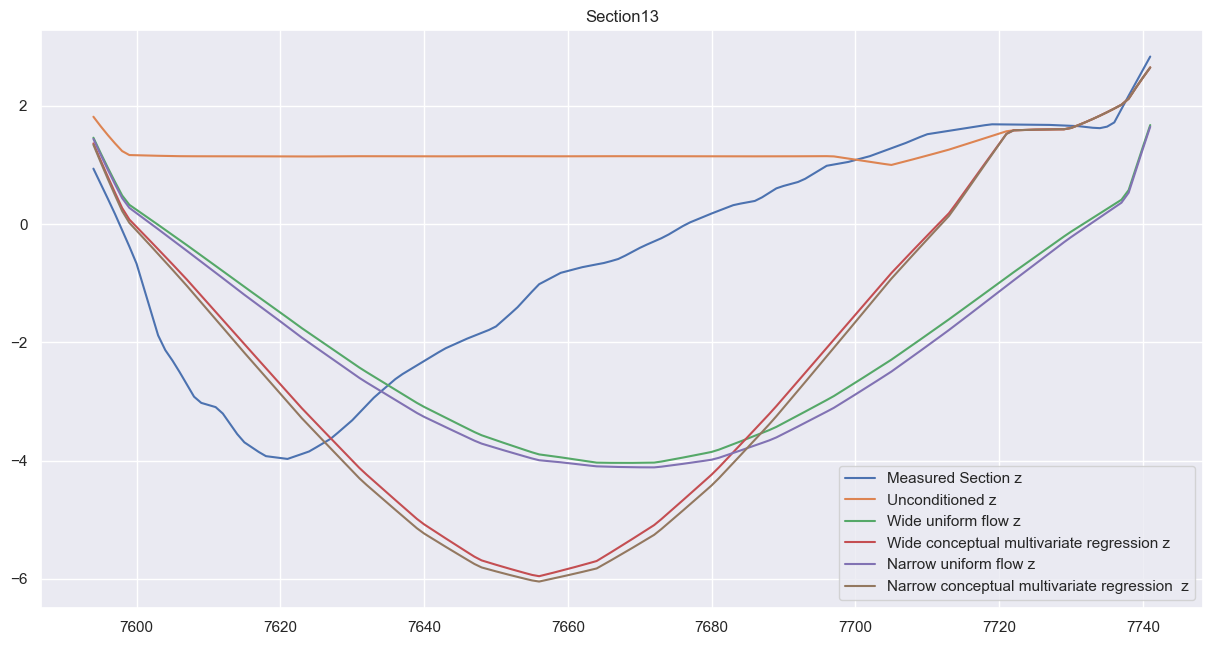

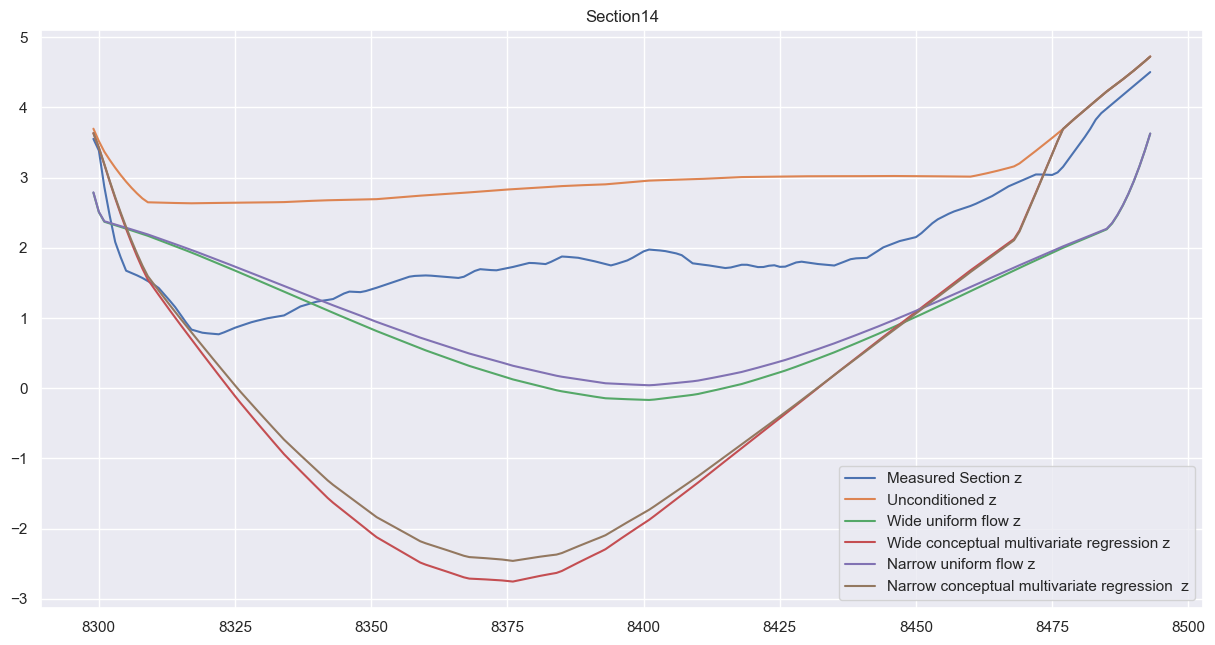

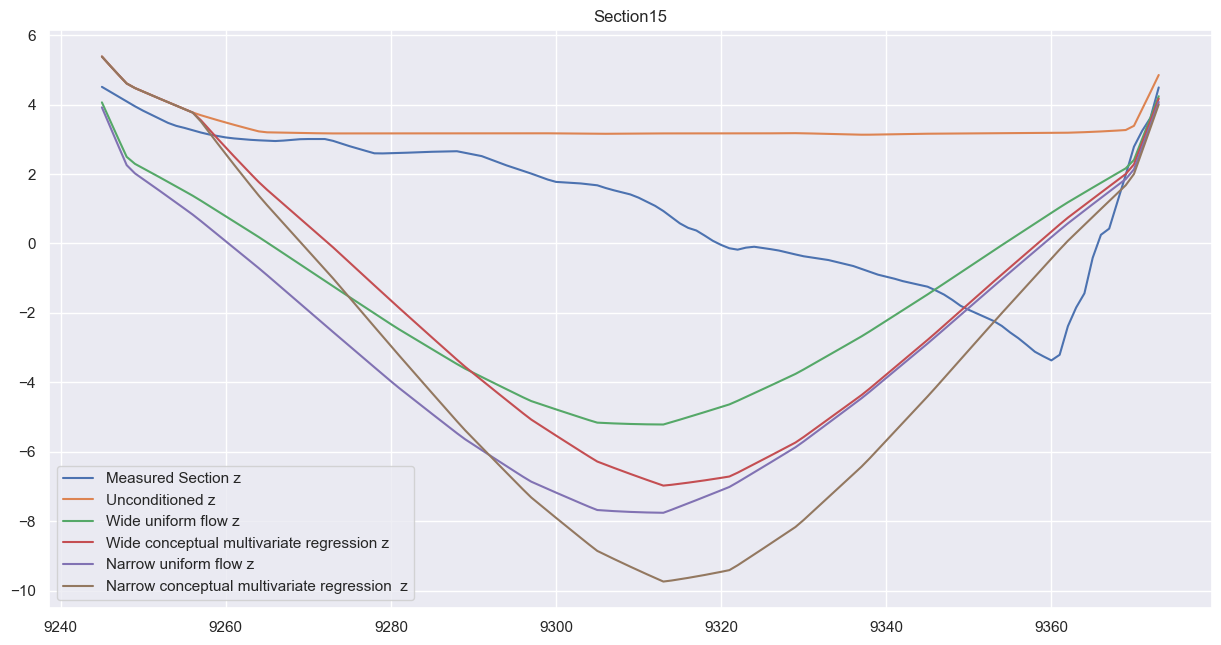

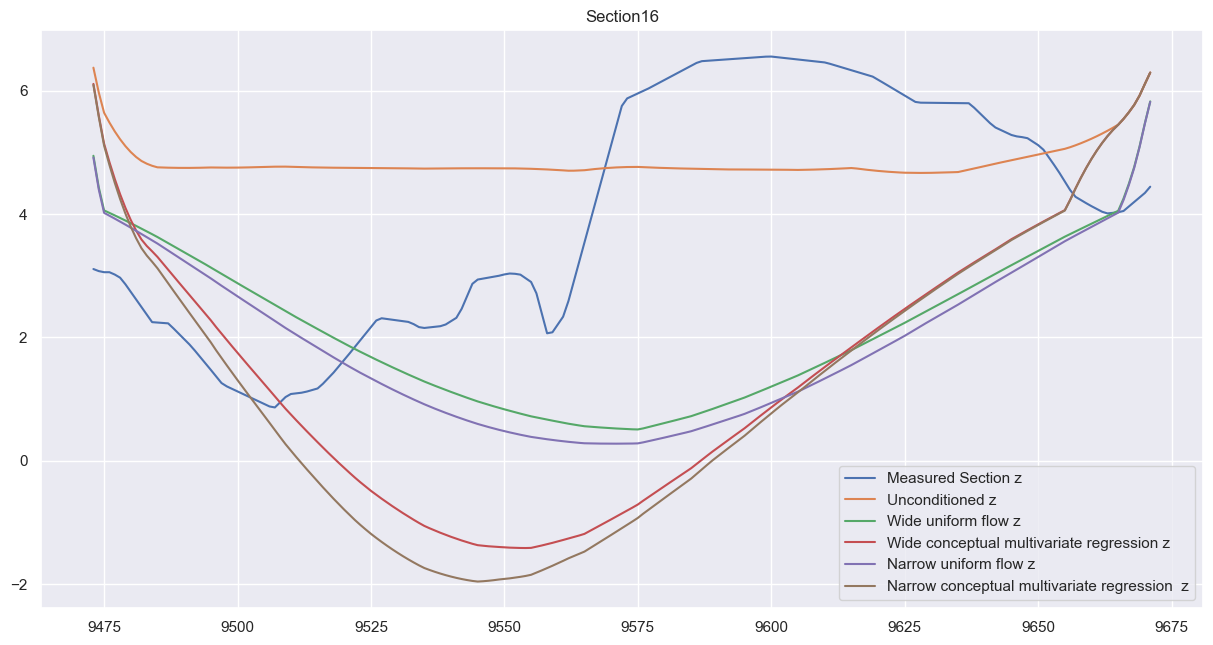

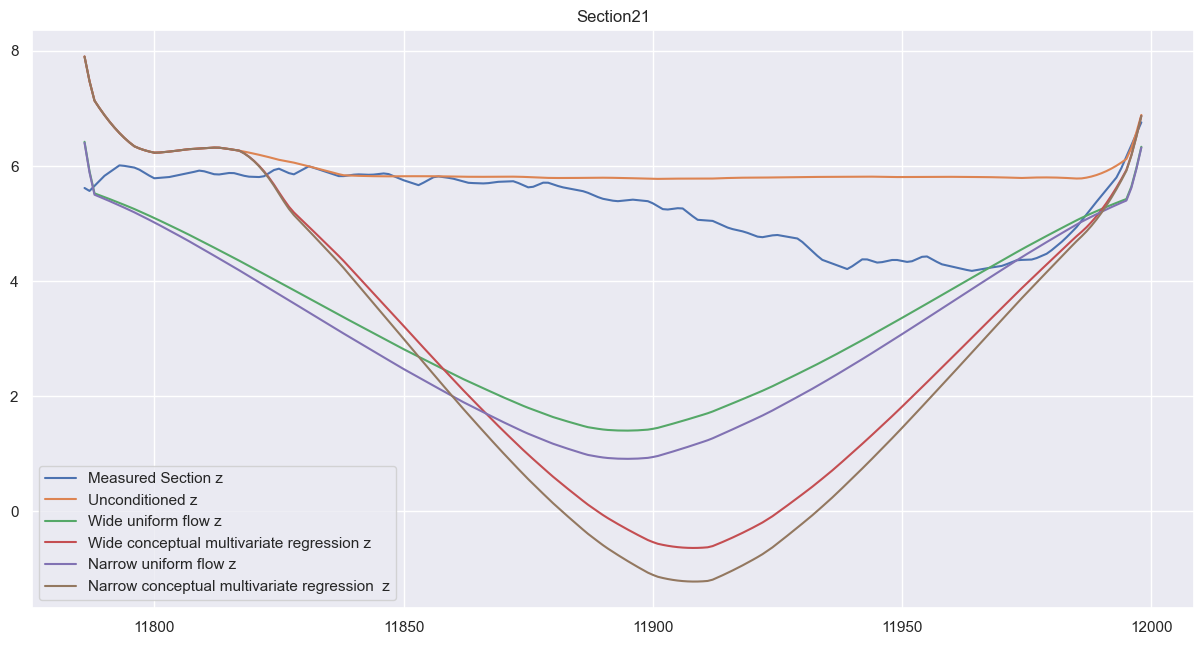

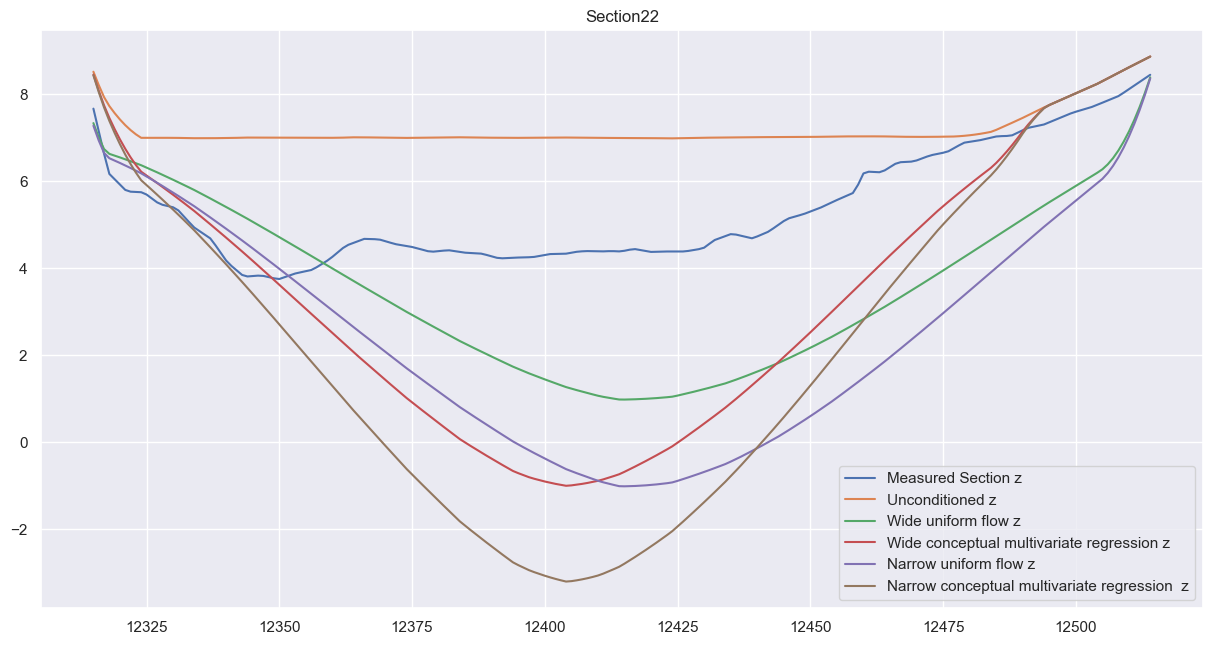

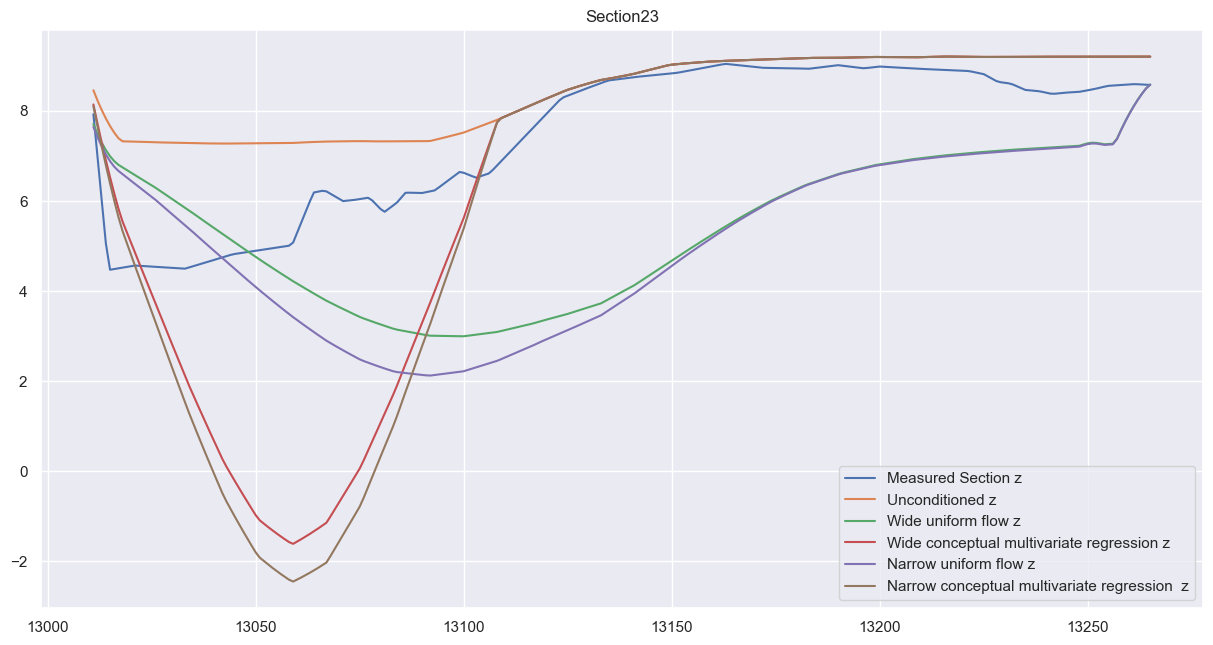

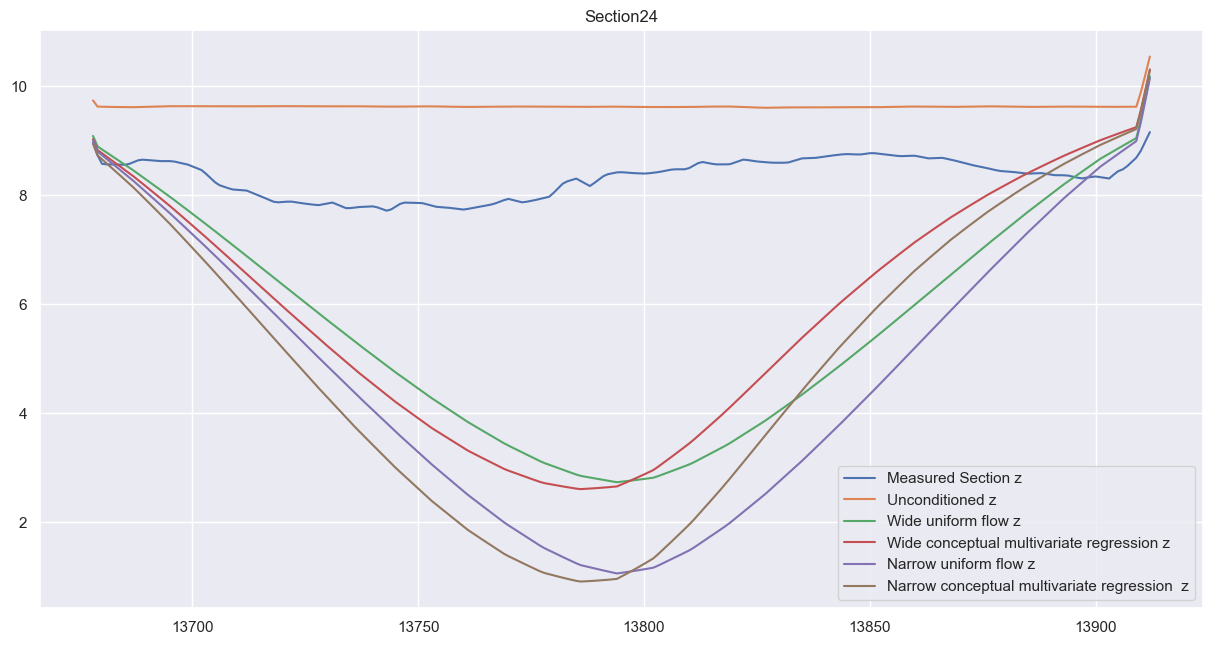

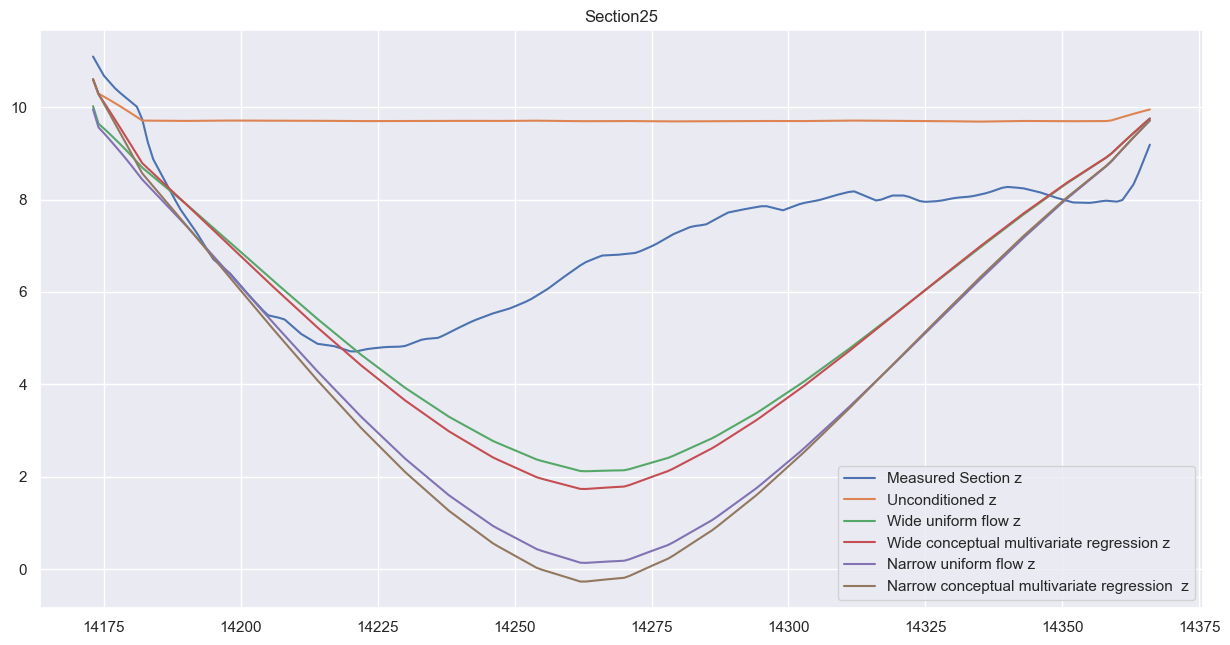

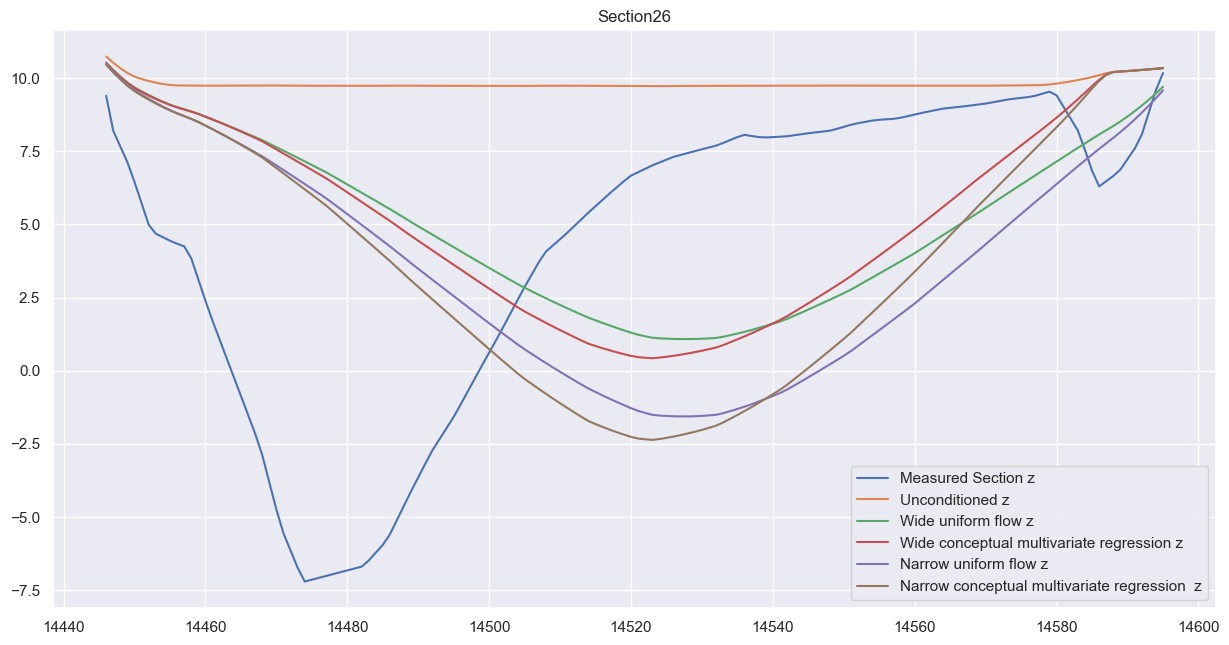

In [58]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in ordered_measured_sections:
    figure = comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled["River"]==True)][columns].plot(title=section);
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"{section}_only_river.png")

## Plot elevation errors along each section
95% confidence interval plot for the errors along each section in the river. Plot the spread of 

In [13]:
for key in dems:
    comparisons_sampled[f"{key} Elevation Errors"] = comparisons_sampled[f"{key} z"] - comparisons_sampled["Measured Section z"]

In [14]:
comparisons_sampled.head(1)

Unconditioned z  Wide uniform flow z  \
0        -0.695949            -3.873493   

   Wide conceptual multivariate regression z  Narrow uniform flow z  \
0                                  -4.422868              -4.409975   

   Narrow conceptual multivariate regression  z  Measured Section z   Section  \
0                                     -4.967281               0.117  Section1   

   River  Distance Upstream [m]  Offset [m]  Unconditioned Elevation Errors  \
0   True                    0.0           0                       -0.812949   

   Wide uniform flow Elevation Errors  \
0                           -3.990493   

   Wide conceptual multivariate regression Elevation Errors  \
0                                          -4.539868          

   Narrow uniform flow Elevation Errors  \
0                             -4.526975   

   Narrow conceptual multivariate regression  Elevation Errors  
0                                          -5.084281

In [15]:
comparisons_sampled

Unconditioned z  Wide uniform flow z  \
0            -0.695949            -3.873493   
1            -0.625069            -3.910827   
2            -0.292314            -3.948228   
3             0.523000            -3.985758   
4             1.340611            -4.023274   
...                ...                  ...   
14650        22.902584            22.902584   
14651        23.090315            23.090315   
14652        23.229323            23.229323   
14653        23.238734            23.238734   
14654        23.206268            23.206268   

       Wide conceptual multivariate regression z  Narrow uniform flow z  \
0                                      -4.422868              -4.409975   
1                                      -4.467429              -4.453933   
2                                      -4.512078              -4.497972   
3                                      -4.556900              -4.542172   
4                                      -4.601704              -4.586354   
...                                          ...                    ...   
14650                                  22.902584              22.902584   
14651                                  23.090315              23.090315   
14652                                  23.229323              23.229323   
14653                                  23.238734              23.238734   
14654                                  23.206268              23.206268   

       Narrow conceptual multivariate regression  z  Measured Section z  \
0                                         -4.967281            0.117000   
1                                         -5.018597            0.717105   
2                                         -5.070016            1.317210   
3                                         -5.121639            1.917315   
4                                         -5.173240            2.517421   
...                                             ...                 ...   
14650                                     22.902584           22.962958   
14651                                     23.090315           23.165177   
14652                                     23.229323           23.367397   
14653                                     23.238734           23.569617   
14654                                     23.206268           23.771837   

         Section  River  Distance Upstream [m]  Offset [m]  \
0       Section1   True                0.00000           0   
1       Section1   True                0.00000           1   
2       Section1   True                0.00000           2   
3       Section1   True                0.00000           3   
4       Section1   True                0.00000           4   
...          ...    ...                    ...         ...   
14650  Section26  False            15294.15571         253   
14651  Section26  False            15294.15571         254   
14652  Section26  False            15294.15571         255   
14653  Section26  False            15294.15571         256   
14654  Section26  False            15294.15571         257   

       Unconditioned Elevation Errors  Wide uniform flow Elevation Errors  \
0                           -0.812949                           -3.990493   
1                           -1.342174                           -4.627933   
2                           -1.609524                           -5.265438   
3                           -1.394315                           -5.903074   
4                           -1.176810                           -6.540694   
...                               ...                                 ...   
14650                       -0.060374                           -0.060374   
14651                       -0.074862                           -0.074862   
14652                       -0.138074                           -0.138074   
14653                       -0.330883                           -0.330883   
14654                       -0.565569           

In [16]:
comparisons_sampled.drop(columns=[f"{key} z" for key in dems]).rename(columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).rename(columns={"Measured Section z": "Measured Section"}).melt(id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]").head()

Section  Distance Upstream [m]  River  Offset [m]        Comparison  \
0  Section1                    0.0   True           0  Measured Section   
1  Section1                    0.0   True           1  Measured Section   
2  Section1                    0.0   True           2  Measured Section   
3  Section1                    0.0   True           3  Measured Section   
4  Section1                    0.0   True           4  Measured Section   

   Riverbed Elevation Error [m]  
0                      0.117000  
1                      0.717105  
2                      1.317210  
3                      1.917315  
4                      2.517421

In [33]:
comparisons_for_plotting=comparisons_sampled.drop(
    columns=[f"{key} z" for key in dems]).drop(columns=["Measured Section z"]).rename(
    columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [34]:
comparisons_for_plotting.to_json(cache_path / folder / "measured_section_comparison" / "compairson_for_plotting.json")

In [60]:
figure

[Text(0.5, 1.0, 'Section Depths Comparison 95% CI')]

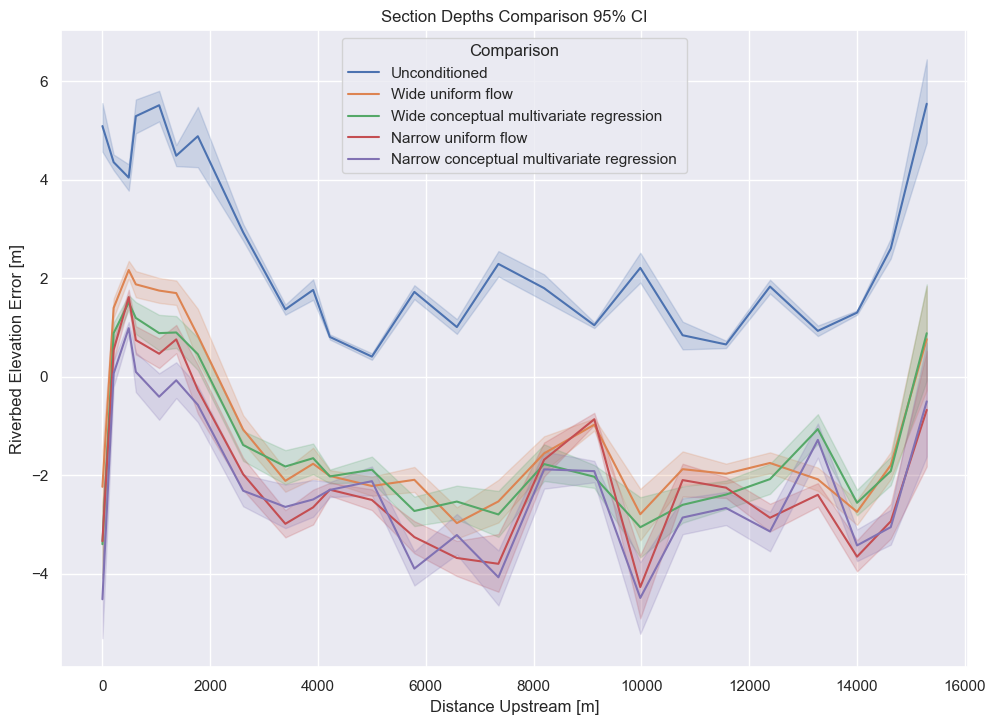

In [61]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison")
figure.set(title='Section Depths Comparison 95% CI')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_depth_errors.png") 

In [20]:
summary = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} z" for key in dems]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
depth_summary = pandas.DataFrame([[summary.mean()[f"{key} Elevation Errors"] for key in dems],
                                  [summary.std()[f"{key} Elevation Errors"] for key in dems]],
                                  index = ["Mean Error", "Standard Deviation"], columns=[key for key in dems])
depth_summary

Unconditioned  Wide uniform flow  \
Mean Error               2.556617          -0.965615   
Standard Deviation       2.634148           3.087201   

                    Wide conceptual multivariate regression  \
Mean Error                                        -1.227417   
Standard Deviation                                 3.116692   

                    Narrow uniform flow  \
Mean Error                    -1.737972   
Standard Deviation             3.281938   

                    Narrow conceptual multivariate regression   
Mean Error                                           -1.976989  
Standard Deviation                                    3.444125

# Channel Area error
The total area of the channel at each section

In [38]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} Elevation Errors" for key in dems]).drop(columns=["River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [39]:
channel_depths.head(1)

Unconditioned z  Wide uniform flow z  \
Distance Upstream [m] Offset [m]                                         
0.0                   0                 -0.695949            -3.873493   

                                  Wide conceptual multivariate regression z  \
Distance Upstream [m] Offset [m]                                              
0.0                   0                                           -4.422868   

                                  Narrow uniform flow z  \
Distance Upstream [m] Offset [m]                          
0.0                   0                       -4.409975   

                                  Narrow conceptual multivariate regression  z  \
Distance Upstream [m] Offset [m]                                                 
0.0                   0                                              -4.967281   

                                  Measured Section z  
Distance Upstream [m] Offset [m]                      
0.0                   0                        0.117

In [40]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
for key in dems:
    channel_depths[key] = section_max_evaluation.rename(columns={"Measured Section z": f"{key} z"}) - channel_depths[[f"{key} z"]]
channel_depths.head(1)

Unconditioned z  Wide uniform flow z  \
Distance Upstream [m] Offset [m]                                         
0.0                   0                 -0.695949            -3.873493   

                                  Wide conceptual multivariate regression z  \
Distance Upstream [m] Offset [m]                                              
0.0                   0                                           -4.422868   

                                  Narrow uniform flow z  \
Distance Upstream [m] Offset [m]                          
0.0                   0                       -4.409975   

                                  Narrow conceptual multivariate regression  z  \
Distance Upstream [m] Offset [m]                                                 
0.0                   0                                              -4.967281   

                                  Measured Section z  Measured Section  \
Distance Upstream [m] Offset [m]                                         
0.0                   0                        0.117          7.505729   

                                  Unconditioned  Wide uniform flow  \
Distance Upstream [m] Offset [m]                                     
0.0                   0                8.318678          11.496222   

                                  Wide conceptual multivariate regression  \
Distance Upstream [m] Offset [m]                                            
0.0                   0                                         12.045598   

                                  Narrow uniform flow  \
Distance Upstream [m] Offset [m]                        
0.0                   0                     12.032704   

                                  Narrow conceptual multivariate regression   
Distance Upstream [m] Offset [m]                                              
0.0                   0                                             12.59001

In [43]:
channel_area = channel_depths.drop(
    columns=["Measured Section z"]).drop(
    columns=[f"{key} z" for key in dems]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

Measured Section  Unconditioned  Wide uniform flow  \
Distance Upstream [m]                                                       
0.0                         2954.598909    1747.821524        3483.852315   

                       Wide conceptual multivariate regression  \
Distance Upstream [m]                                            
0.0                                                 3759.96552   

                       Narrow uniform flow  \
Distance Upstream [m]                        
0.0                            3745.380472   

                       Narrow conceptual multivariate regression   
Distance Upstream [m]                                              
0.0                                                   4025.003227

In [44]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

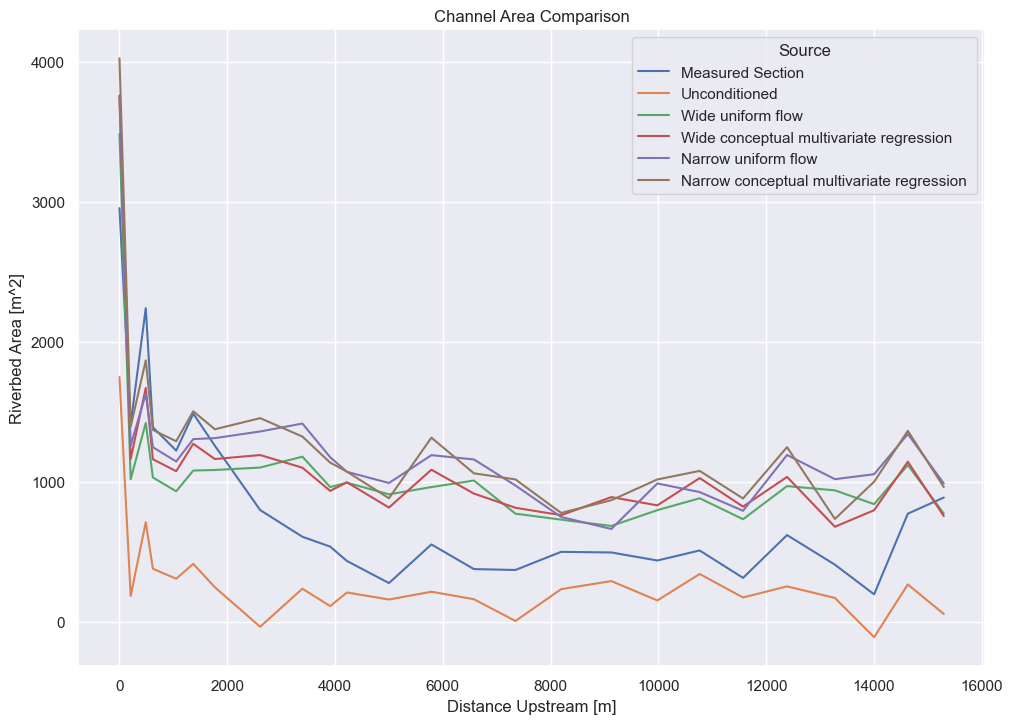

In [63]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
figure.set(title='Channel Area Comparison')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 

# Exploring potential sources of error
## 1. Using measured versus estimate flow
The flow guage stations provide measured mean-annual flood flows. These can be used instead of the estimated ones across NZ. We can look at the impact of the different values by simply scaling the depths and then rerunning the generate hydrologically conditioned DEM steps.

#### Measured flow guage data
* [Te Kuha](https://www.lawa.org.nz/explore-data/west-coast-region/water-quantity/monitoring-sites/buller-rv-te-kuha/) - 3727.09 m³/s

#### Estimated flow data
* Te Kuha section NZREACH ID 12012463 - 4225.07 m³/s

#### Scaling to the different depths
In both cases the equation can be re-arragned to: h=(n/wS^b)^1/(1+a)*Q^1/(1+a) where 1/(1+a) differs in each case.
So depth can be scaled by (Qnew/Qold) ^ 1/(1+a). Where Qnew/Qold = 0.8821368640046201.
This means in each case:
* Uniform flow - 1/(1+a) = 0.6 -> x 0.9275163689031669
* Conceptual multivariate regression - 1/(1+a) = 0.573 -> x 0.9306622787286434
So depth can be scaled by (Qnew/Qold) ^ 1/(1+a)

## 2. Different thresholds
##### Currently
* narrow is 0.5 min to 0.75 max
* wide is 2 min to 5 max
Looking through the sampled sections it looks like the banks are higher than  5m generally (at least for bank full flow), and the water section could be less than 2m - try say 1m min, 10 max
## 3. 

In [74]:
river_depths = geopandas.read_file(cache_path / folder / "wide_river" / "river_bathymetry.geojson")
river_depths_all = geopandas.read_file(cache_path / folder / "wide_river" / "river_characteristics.geojson")

In [75]:
river_depths_all.columns

Index(['min_z_centre', 'min_z_centre_unimodal', 'min_z_water', 'slope',
       'min_z_centre_unimodal_mean_0.05km', 'slope_mean_0.05km',
       'min_z_centre_unimodal_mean_0.25km', 'slope_mean_0.25km',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km', 'widths',
       'threshold', 'channel_count', 'flat_widths', 'valid', 'valid_widths',
       'valid_flat_widths', 'valid_threhold', 'widths_mean_0.05km',
       'flat_widths_mean_0.05km', 'thresholds_mean_0.05km',
       'widths_mean_0.15km', 'flat_widths_mean_0.15km',
       'thresholds_mean_0.15km', 'widths_mean_0.2km', 'flat_widths_mean_0.2km',
       'thresholds_mean_0.2km', 'widths_mean_0.25km',
       'flat_widths_mean_0.25km', 'thresholds_mean_0.25km', 'geometry'],
      dtype='object')

In [98]:
river_depths.head(0)

Empty GeoDataFrame
Columns: [bed_elevation_Neal_et_al, bed_elevation_Rupp_and_Smart, bank_height, width, flat_widths_mean_0.05km, depth_Neal_et_al, depth_Rupp_and_Smart, flood_depth_Neal_et_al, flood_depth_Rupp_and_Smart, geometry]
Index: []

<Axes: >

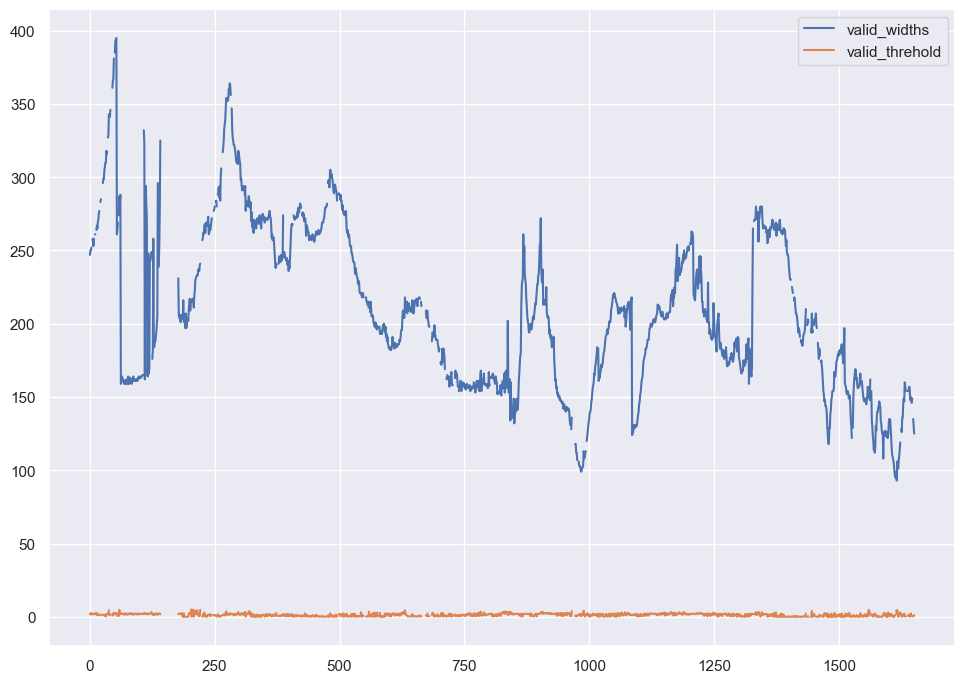

In [99]:
river_depths_all[["valid", "valid_widths", "valid_threhold"]].plot()

<Axes: >

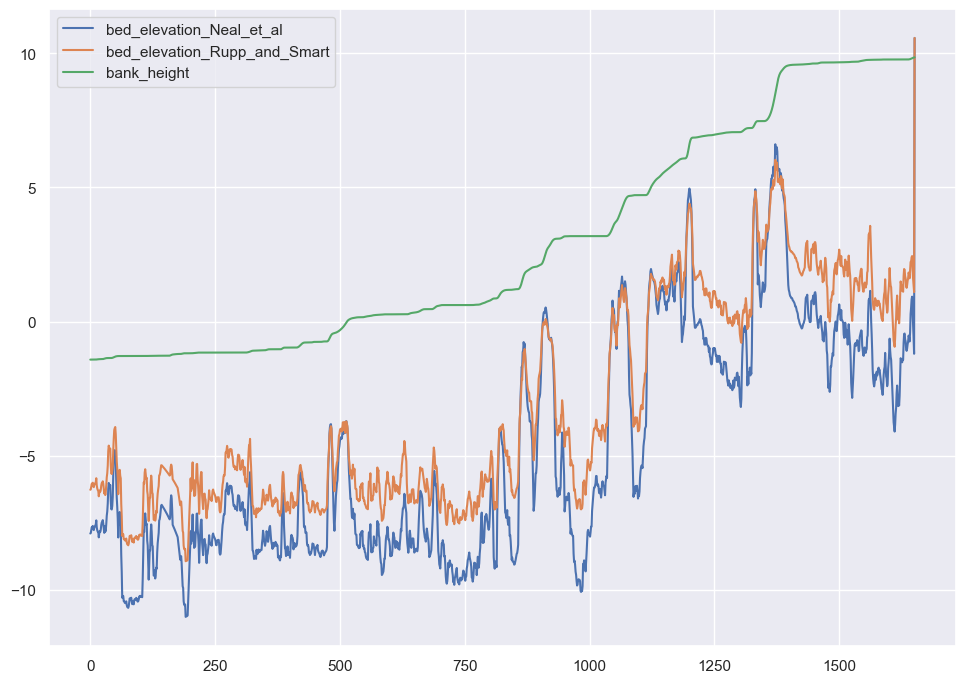

In [69]:
river_depths[["bed_elevation_Neal_et_al", "bed_elevation_Rupp_and_Smart", "bank_height"]].plot()

<Axes: >

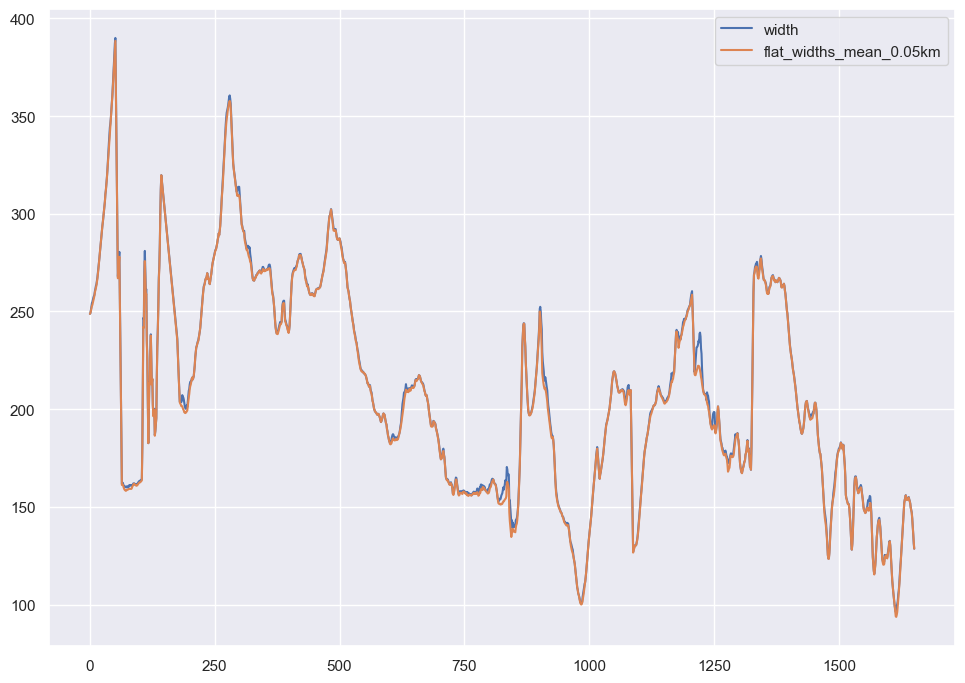

In [72]:
river_depths[["width", "flat_widths_mean_0.05km"]].plot()

<Axes: >

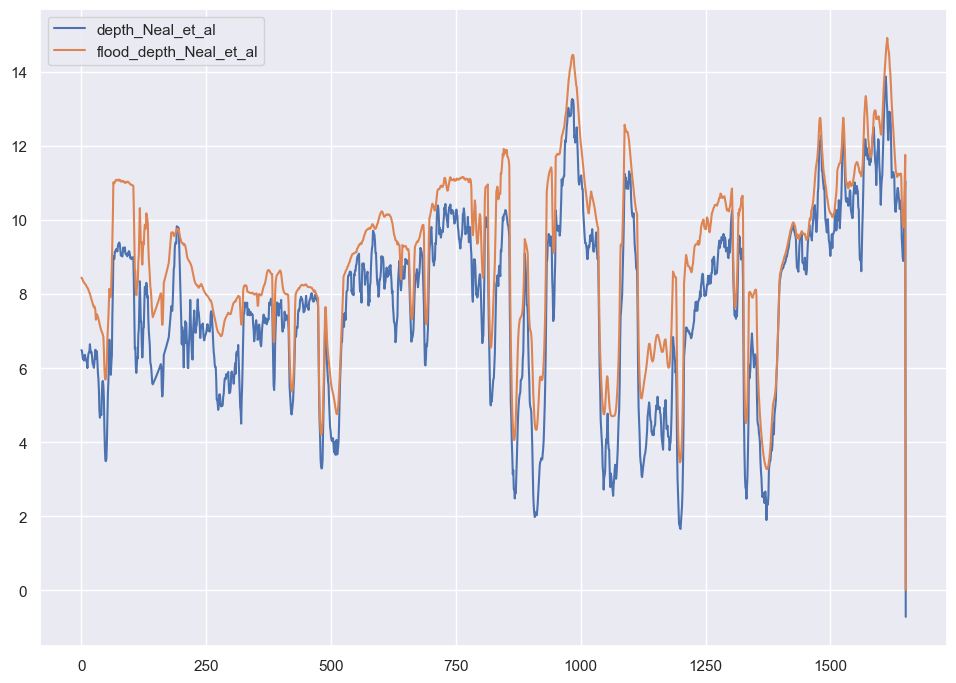

In [73]:
river_depths[["depth_Neal_et_al", "flood_depth_Neal_et_al"]].plot()

<Axes: >

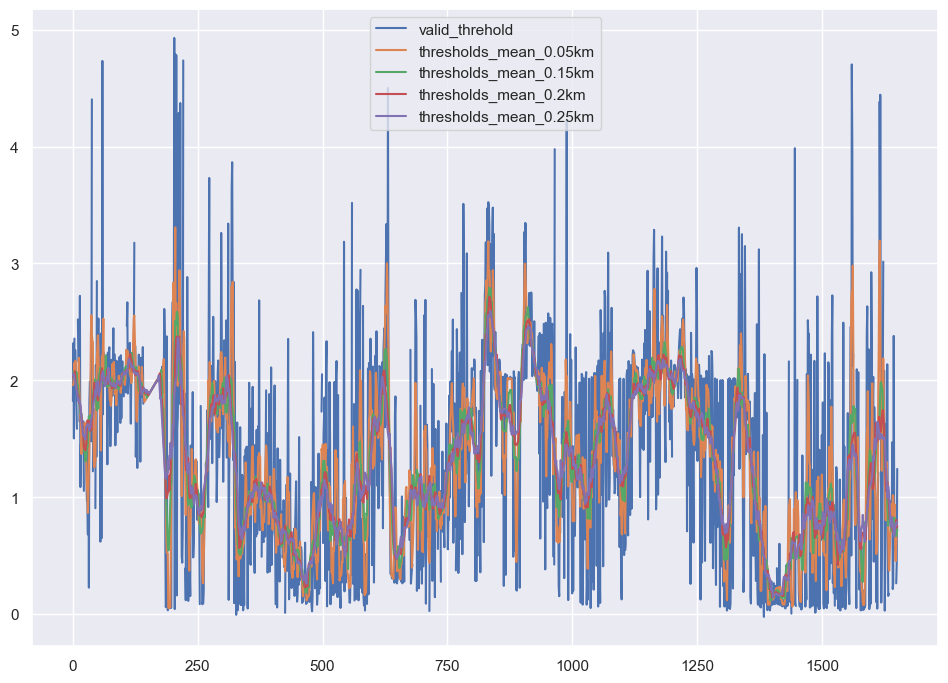

In [101]:
river_depths_all[["valid_threhold", "thresholds_mean_0.05km", "thresholds_mean_0.15km", "thresholds_mean_0.2km", "thresholds_mean_0.25km"]].plot() # "threshold", 

<Axes: >

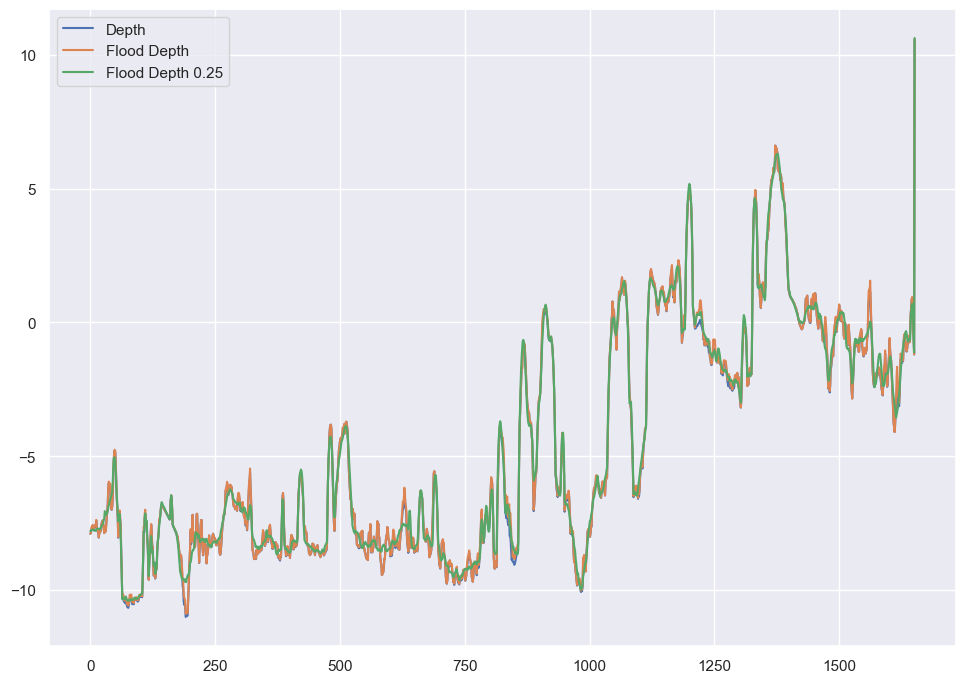

In [95]:
pandas.concat({"Depth":(river_depths_all["min_z_centre_unimodal"] - river_depths["depth_Neal_et_al"]),
               "Flood Depth": (river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]),
               "Flood Depth 0.25": (river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.25km"])},axis=1).plot()

<Axes: >

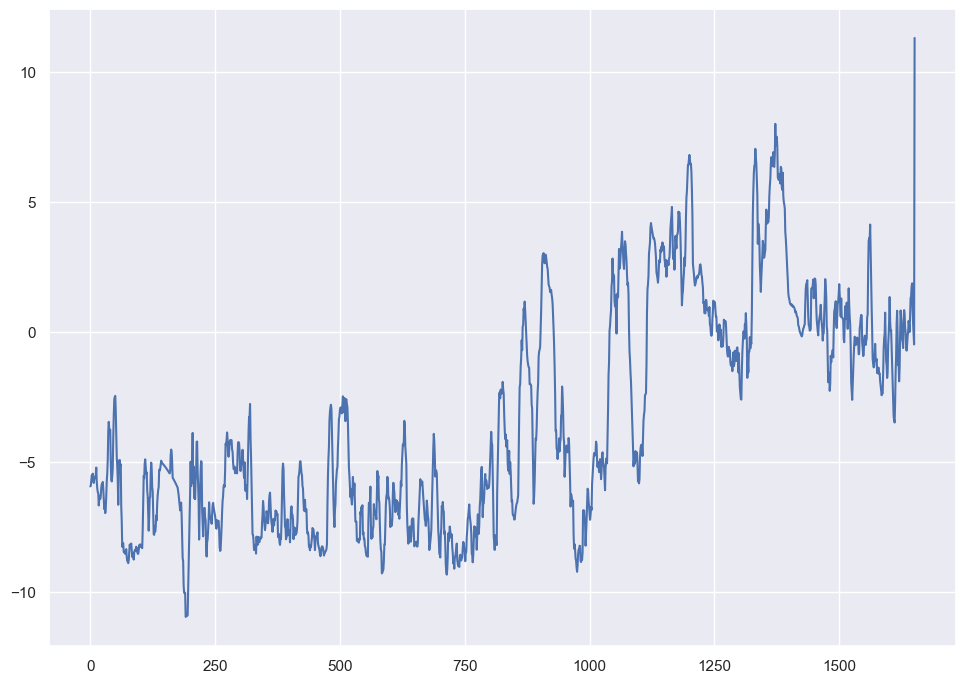

In [80]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]).plot()

<Axes: >

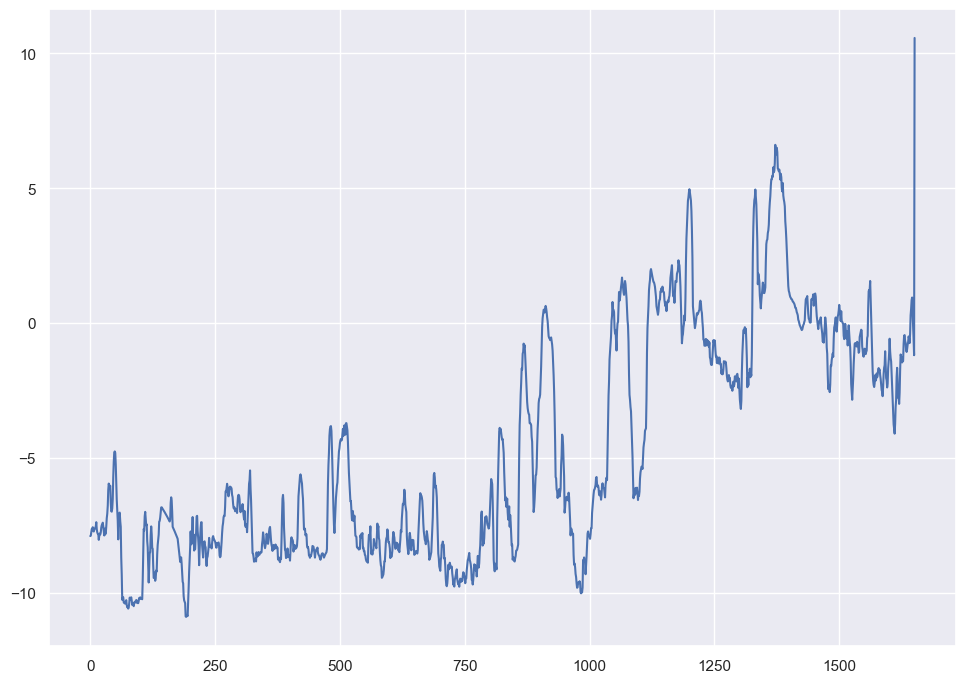

In [82]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]).plot()

<Axes: >

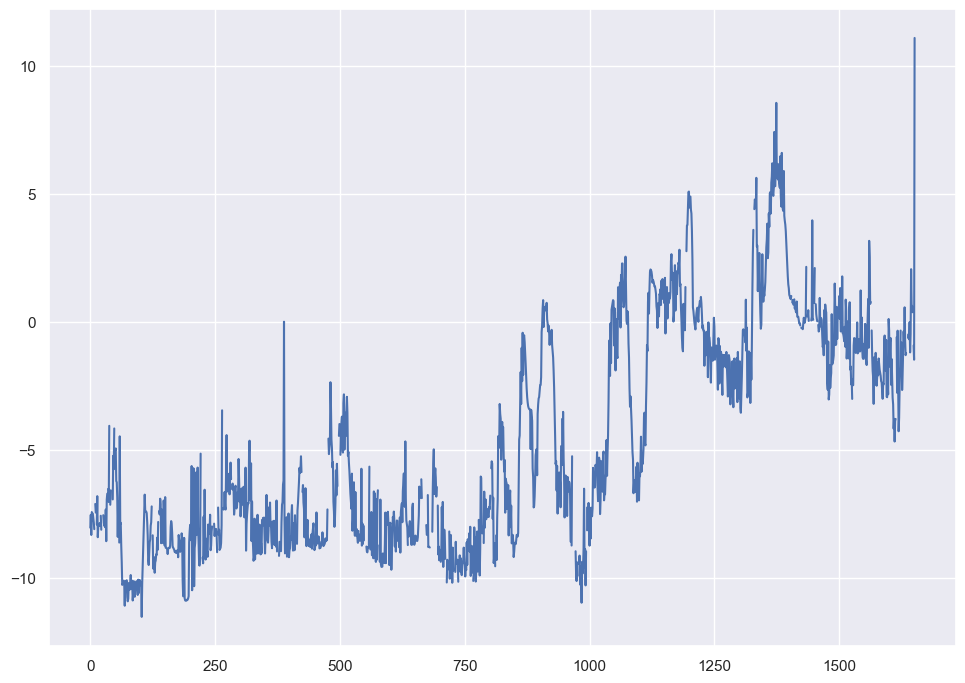

In [83]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["threshold"]).plot()